# **EEE-CIS Fraud Detection** #

* The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features.

### What is Fraud Detection?

* Fraud detection protects person information, assets, accounts and transactions through the real-time, near-real-time analysis of activities by users and other defined entities. It uses background server-based processes that examine users’ and other defined entities’ access and behavior patterns, and typically compares this information to a profile of what’s expected.

### Data Description

* TransactionDT: Timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: Transaction payment amount in USD
* ProductCD: Product code, the product for each transaction
* card1 - card6: Payment card information, such as card type, card category, issue bank, country, etc.
* addr: Address
* dist: Distance
* P_ and R_emaildomain: Purchaser and recipient email domain
* C1-C14: Counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: Timedelta, such as days between previous transaction, etc.
* M1-M9: mMatch, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

* Categorical Features: ProductCD, card1 - card6, addr1, addr2, P_emaildomain, R_emaildomain, M1 - M9

### Identity Table

* Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

* Categorical Features: DeviceType, DeviceInfo, id_12 - id_38

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [2]:
import gc
import time
import datetime
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score
from sklearn import metrics, preprocessing

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder


pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns',700)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# Reduce Memory Usage


In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# Loading Data


In [4]:
train_transaction = pd.read_csv("/content/drive/MyDrive/AIE Experiments/kaggle/input/ieee-fraud-detection/train_transaction.csv")
train_identity = pd.read_csv("/content/drive/MyDrive/AIE Experiments/kaggle/input/ieee-fraud-detection/train_identity.csv")

test_transaction = pd.read_csv("/content/drive/MyDrive/AIE Experiments/kaggle/input/ieee-fraud-detection/test_transaction.csv")
test_identity = pd.read_csv("/content/drive/MyDrive/AIE Experiments/kaggle/input/ieee-fraud-detection/test_identity.csv")

# Fix Column Name
fix_col_name = {testIdCol:trainIdCol for testIdCol, trainIdCol in zip(test_identity.columns, train_identity.columns)}
test_identity.rename(columns=fix_col_name, inplace=True)

# Reduce Memory
train_transaction = reduce_mem_usage(train_transaction)
train_identity = reduce_mem_usage(train_identity)

test_transaction = reduce_mem_usage(test_transaction)
test_identity = reduce_mem_usage(test_identity)

# Merge (transaction - identity)
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test = test_transaction.merge(test_identity, on='TransactionID', how='left')

# Merge (X_train - X_test)
train_test = pd.concat([train, test], ignore_index=True)

print(f'train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

del train_transaction, train_identity, test_transaction, test_identity; x = gc.collect()

Mem. usage decreased to 916.30 Mb (48.4% reduction)
Mem. usage decreased to 31.91 Mb (29.3% reduction)
Mem. usage decreased to 785.71 Mb (48.3% reduction)
Mem. usage decreased to 31.40 Mb (29.3% reduction)
train dataset has 590540 rows and 434 columns.
test dataset has 506691 rows and 433 columns.


In [5]:
train_test = train_test.copy()
train = train.copy()
test = test.copy()

# Exploratory Data Analysis (EDA)

In [6]:
def check_df(df, head=5):
    print("##################### Shape #####################")
    print(df.shape)

    print("##################### Types #####################")
    print(df.dtypes)

    print("##################### Head #####################")
    print(df.head(head))

    print("##################### NA #####################")
    print(df.isnull().sum())

check_df(train)

##################### Shape #####################
(590540, 434)
##################### Types #####################
TransactionID       int32
isFraud              int8
TransactionDT       int32
TransactionAmt    float32
ProductCD          object
card1               int16
card2             float32
card3             float32
card4              object
card5             float32
card6              object
addr1             float32
addr2             float32
dist1             float32
dist2             float32
P_emaildomain      object
R_emaildomain      object
C1                float32
C2                float32
C3                float32
C4                float32
C5                float32
C6                float32
C7                float32
C8                float32
C9                float32
C10               float32
C11               float32
C12               float32
C13               float32
C14               float32
D1                float32
D2                float32
D3                float32
D4

In [7]:
# Function of Missing Values

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 1)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df , end="\n")
    if na_name:
        return na_columns

missing_values_table(train, na_name=False)

               n_miss  ratio
id_24          585793 99.200
id_25          585408 99.100
id_07          585385 99.100
id_08          585385 99.100
id_21          585381 99.100
id_26          585377 99.100
id_27          585371 99.100
id_23          585371 99.100
id_22          585371 99.100
dist2          552913 93.600
D7             551623 93.400
id_18          545427 92.400
D13            528588 89.500
D14            528353 89.500
D12            525823 89.000
id_03          524216 88.800
id_04          524216 88.800
D6             517353 87.600
id_33          517251 87.600
id_10          515614 87.300
id_09          515614 87.300
D8             515614 87.300
D9             515614 87.300
id_30          512975 86.900
id_32          512954 86.900
id_34          512735 86.800
id_14          510496 86.400
V155           508595 86.100
V138           508595 86.100
V156           508595 86.100
V157           508595 86.100
V158           508595 86.100
V154           508595 86.100
V153          

## Exploring Target Features - isFraud


In [8]:
train_fraud = train.loc[train['isFraud'] == 1]
train_non_fraud = train.loc[train['isFraud'] == 0]

train['isFraud'].value_counts(normalize=True)

0   0.965
1   0.035
Name: isFraud, dtype: float64

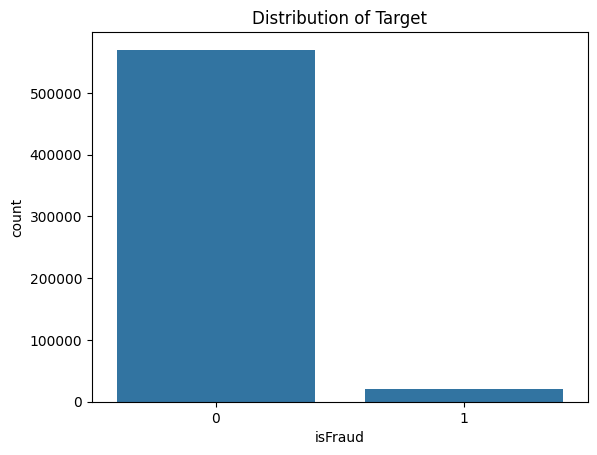

In [9]:
sns.countplot(x="isFraud", data=train).set_title('Distribution of Target')
plt.show()

## Exploring Continuous Features


#### TransactionDT
* TransactionDT : is a timedelta from a given reference datetime (not an actual timestamp).
* TransactionDT is one of the features that can cause problems.
* It seems as if there is a time difference between testing and train operations.

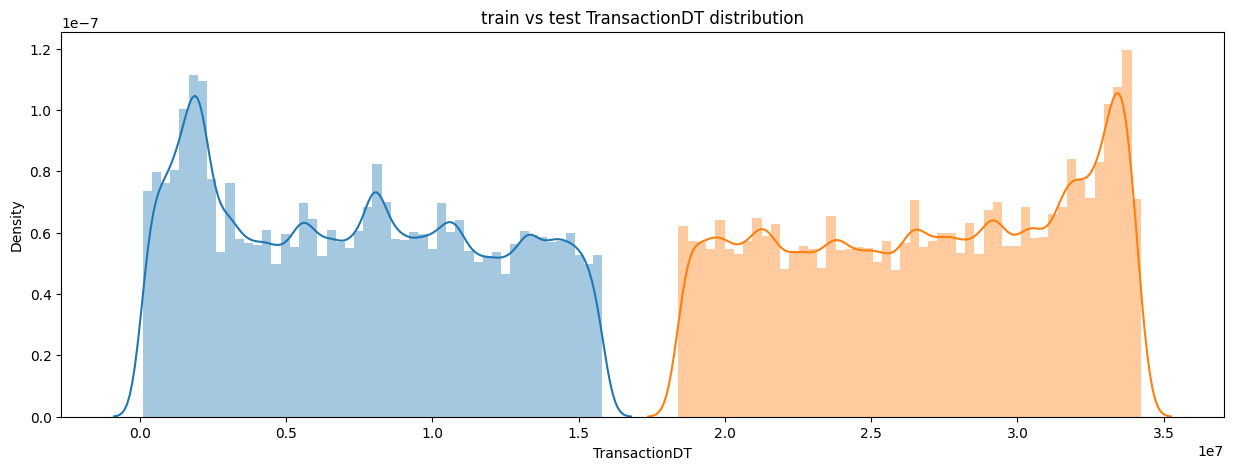

In [10]:
plt.figure(figsize=(15,5))
sns.distplot(train["TransactionDT"])
sns.distplot(test["TransactionDT"])
plt.title('train vs test TransactionDT distribution')
plt.show()

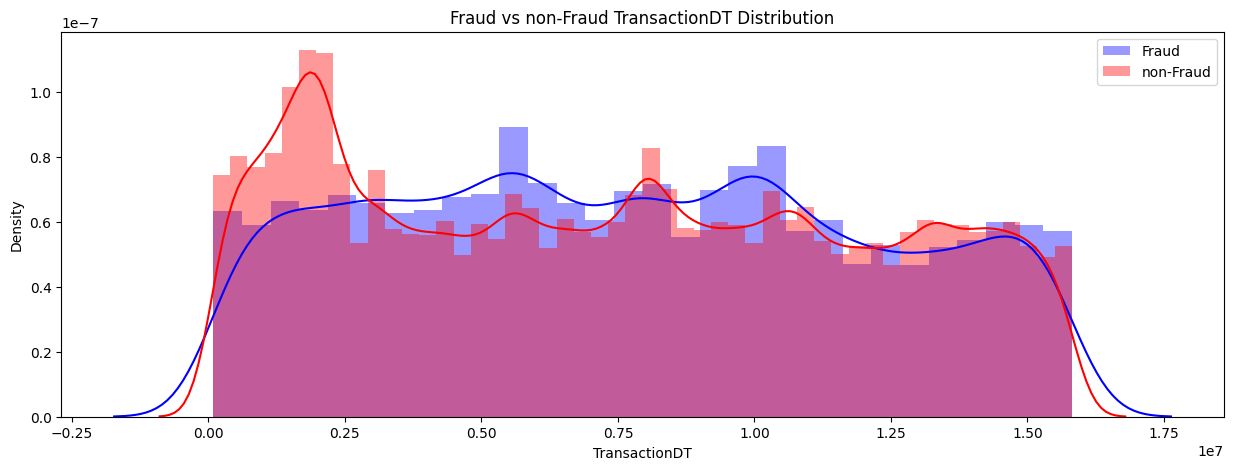

In [11]:
plt.figure(figsize=(15,5))
sns.distplot(train_fraud["TransactionDT"], color='b', label='Fraud')
sns.distplot(train_non_fraud["TransactionDT"], color='r', label ='non-Fraud')
plt.title('Fraud vs non-Fraud TransactionDT Distribution')
plt.legend()

##### Feature Extraction Taking the start date ‘2015-04-22’, constructed time variables. In discussions tab you should read an excellent solutions.

<Axes: xlabel='New_Date_YearMonth'>

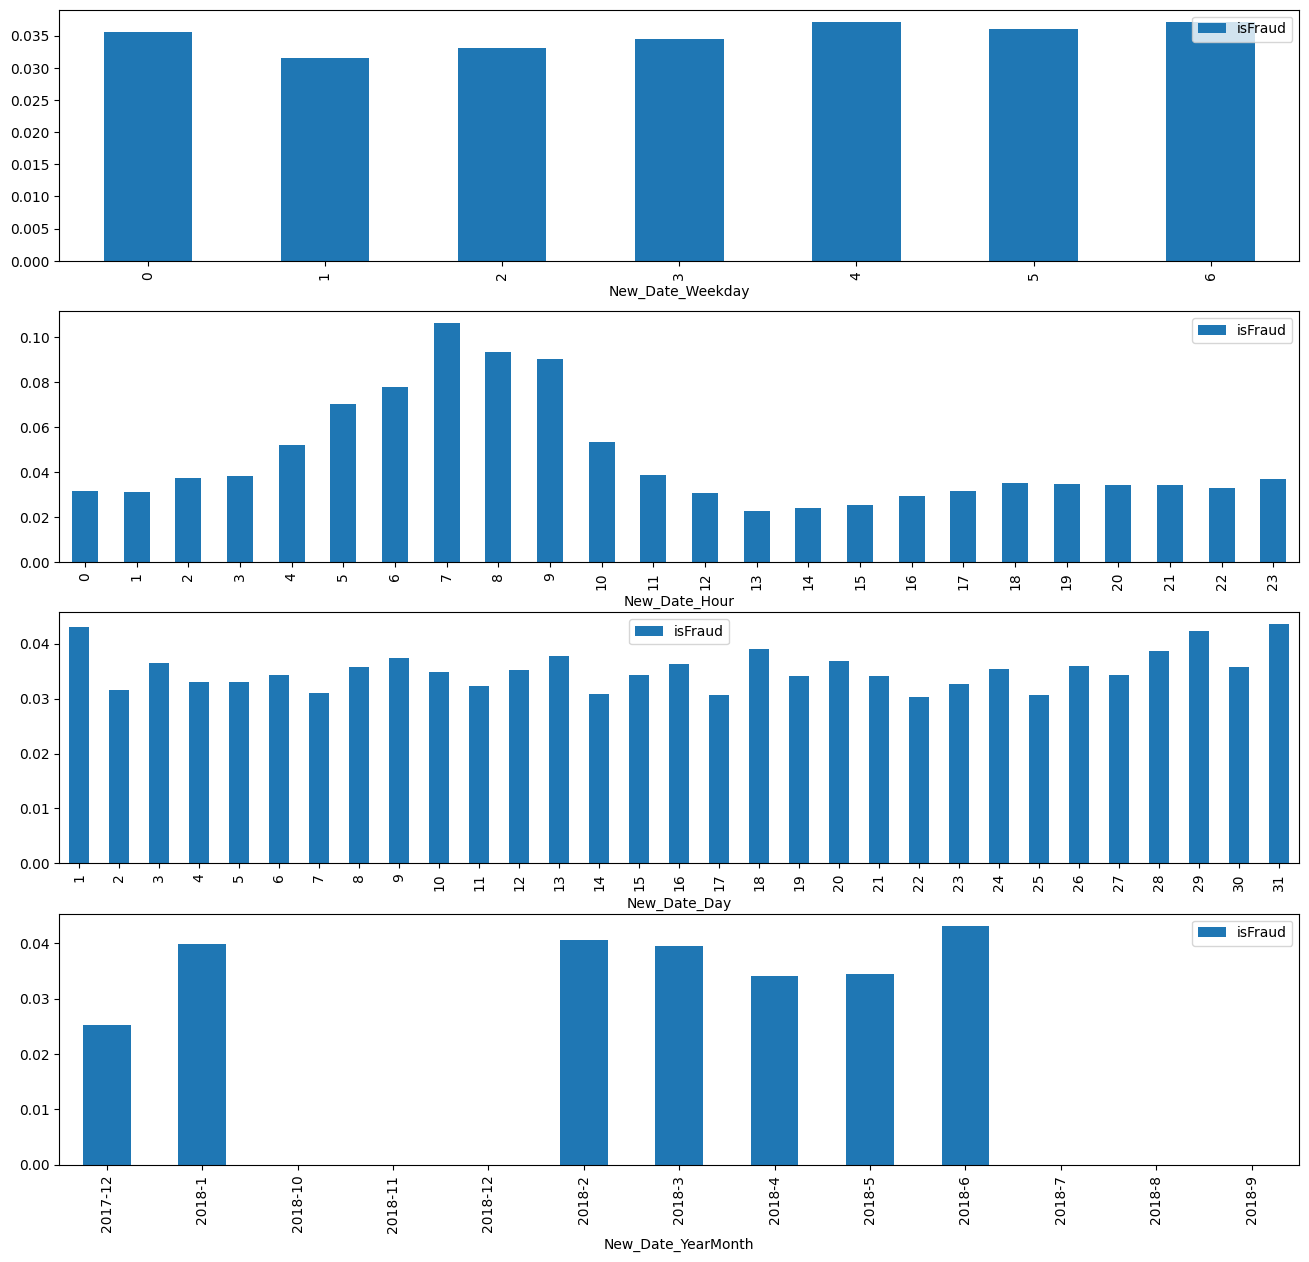

In [12]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

train_test['New_Date'] = train_test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_test['New_Date_YMD'] = train_test['New_Date'].dt.year.astype(str) + '-' + train_test['New_Date'].dt.month.astype(str) + '-' + train_test['New_Date'].dt.day.astype(str)
train_test['New_Date_YearMonth'] = train_test['New_Date'].dt.year.astype(str) + '-' + train_test['New_Date'].dt.month.astype(str)
train_test['New_Date_Weekday'] = train_test['New_Date'].dt.dayofweek
train_test['New_Date_Hour'] = train_test['New_Date'].dt.hour
train_test['New_Date_Day'] = train_test['New_Date'].dt.day


fig,ax = plt.subplots(4, 1, figsize=(16,15))

train_test.groupby('New_Date_Weekday')['isFraud'].mean().to_frame().plot.bar(ax=ax[0])
train_test.groupby('New_Date_Hour')['isFraud'].mean().to_frame().plot.bar(ax=ax[1])
train_test.groupby('New_Date_Day')['isFraud'].mean().to_frame().plot.bar(ax=ax[2])
train_test.groupby('New_Date_YearMonth')['isFraud'].mean().to_frame().plot.bar(ax=ax[3])


#### TransactionAmt

* TransactionAmt : The ammount of transaction.
* I apply log transform in order to better show the distribution of data. Otherwise very large transactions skew the distribution.
* The mean of the fraud transaction amount is larger than the mean of non - fraud transaction amount.
* And also , the lowest and highest transaction amounts seem to be more likely to be fraudulent transactions.


In [13]:
print(pd.concat([train['TransactionAmt'].quantile([.01, .1, .25, .5, .75, .9, .99]).reset_index(),
                 train_fraud['TransactionAmt'].quantile([.01, .1, .25, .5, .75, .9, .99]).reset_index(),
                 train_non_fraud['TransactionAmt'].quantile([.01, .1, .25, .5, .75, .9, .99]).reset_index()],
                   axis=1, keys=['Total','Fraud', "No Fraud"]))

  Total                Fraud                No Fraud               
  index TransactionAmt index TransactionAmt    index TransactionAmt
0 0.010          9.242 0.010          6.739    0.010          9.512
1 0.100         25.953 0.100         18.938    0.100         26.312
2 0.250         43.312 0.250         35.031    0.250         43.969
3 0.500         68.750 0.500         75.000    0.500         68.500
4 0.750        125.000 0.750        161.000    0.750        120.000
5 0.900        275.250 0.900        335.000    0.900        267.100
6 0.990       1104.000 0.990        994.000    0.990       1104.000


In [14]:
print(' Fraud TransactionAmt mean      :  '+str(train_fraud['TransactionAmt'].mean()))
print(' Non - Fraud TransactionAmt mean:  '+str(train_non_fraud['TransactionAmt'].mean()))

 Fraud TransactionAmt mean      :  149.24435
 Non - Fraud TransactionAmt mean:  134.51186


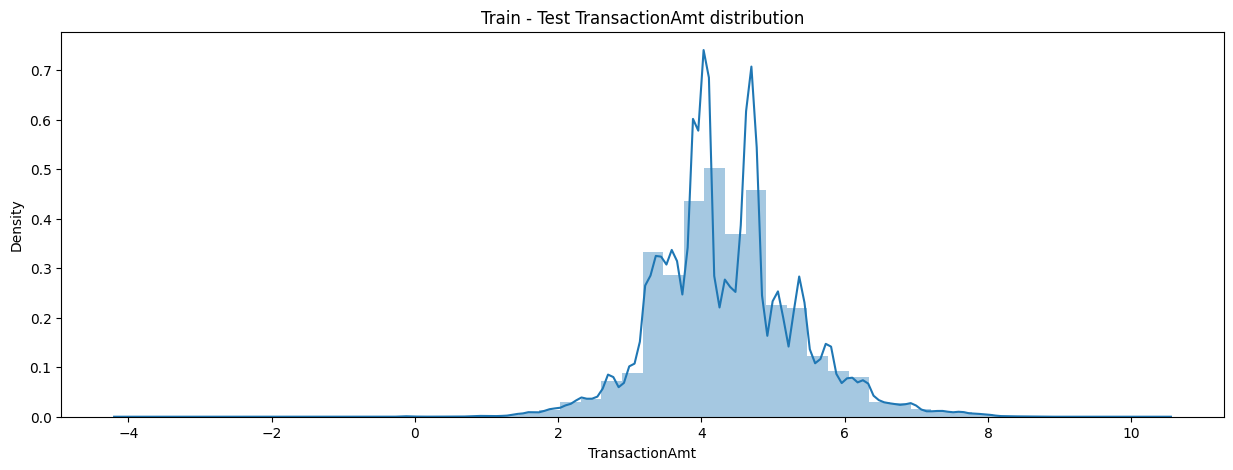

In [15]:
plt.figure(figsize=(15,5))
sns.distplot(train_test["TransactionAmt"].apply(np.log))
plt.title('Train - Test TransactionAmt distribution')
plt.show()

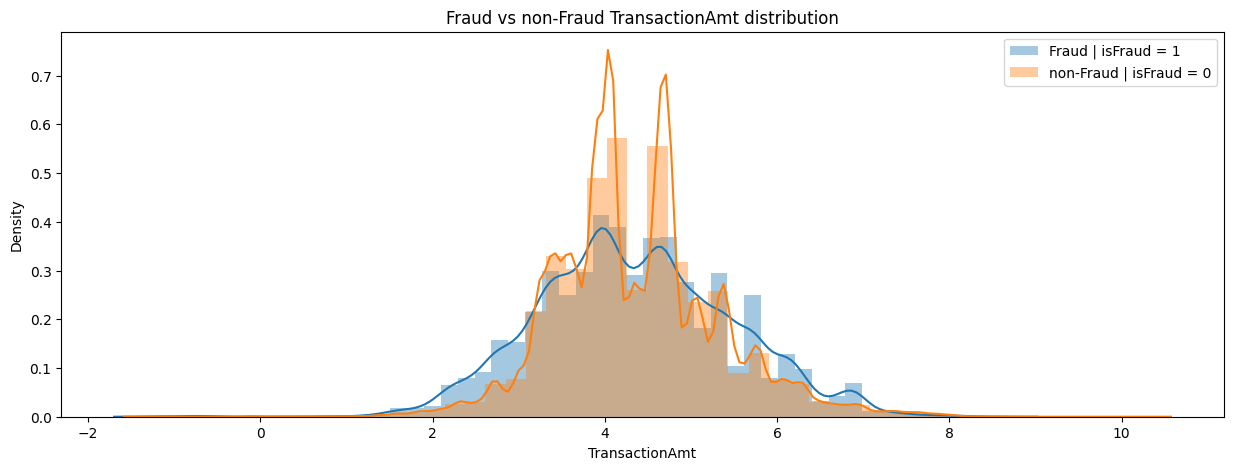

In [16]:
plt.figure(figsize=(15,5))
sns.distplot(train_fraud["TransactionAmt"].apply(np.log), label = 'Fraud | isFraud = 1')
sns.distplot(train_non_fraud["TransactionAmt"].apply(np.log), label = 'non-Fraud | isFraud = 0')
plt.title('Fraud vs non-Fraud TransactionAmt distribution')
plt.legend()
plt.show()

In [17]:
train['New_TransactionAmt_Bin'] = pd.qcut(train['TransactionAmt'],15)
train.groupby('New_TransactionAmt_Bin')[['isFraud']].mean()

isFraud
New_TransactionAmt_Bin         
(0.25, 24.0]              0.071
(24.0, 29.5]              0.032
(29.5, 35.938]            0.029
(35.938, 47.0]            0.041
(47.0, 50.0]              0.022
(50.0, 57.938]            0.018
(57.938, 59.0]            0.021
(59.0, 77.938]            0.044
(77.938, 100.0]           0.034
(100.0, 107.938]          0.014
(107.938, 117.0]          0.024
(117.0, 160.0]            0.043
(160.0, 226.0]            0.036
(226.0, 335.0]            0.049
(335.0, 31936.0]          0.051

#### dist1 & dist2
* Perhaps this could be the distance of the transaction vs. the card owner's home/work address.

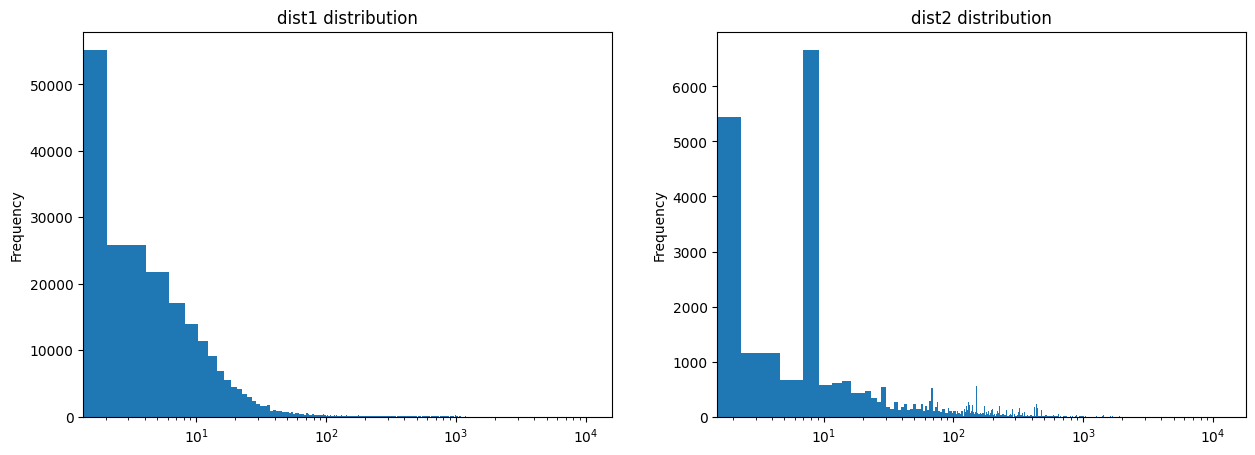

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
train['dist1'].plot(kind='hist',bins=5000,ax=ax1,title='dist1 distribution',logx=True)
train['dist2'].plot(kind='hist',bins=5000,ax=ax2,title='dist2 distribution',logx=True)
plt.show()

## Exploring Categorical Features

In this section, I will examine the effect of categorical variables on fraud.

Although some of the group features are categorical(like M, card, id_), I will examine them in a diffrent section.

### Categorical Features
* ProductCD
* addr1 & addr2
* P_emaildomain & R_emaildomain
* DeviceType
* DeviceInfo


In [19]:
def getCatFeatureDetail(df,cat_cols):
    cat_detail_dict = {}
    for col in cat_cols:
        cat_detail_dict[col] = df[col].nunique()
    cat_detail_df = pd.DataFrame.from_dict(cat_detail_dict, orient='index', columns=['nunique'])
    print('There are ' + str(len(cat_cols)) + ' categorical columns.')
    print(cat_detail_df)

cat_features = ['isFraud','ProductCD','addr1', 'addr2', 'P_emaildomain','R_emaildomain','DeviceType','DeviceInfo']
all_cat_features = cat_features+ [f'card{i}' for i in range(1,7)]+ [f'M{i}' for i in range(1,10)] + [f'id_{i}' for i in range(12,39)]

getCatFeatureDetail(train_test, cat_features)

There are 8 categorical columns.
               nunique
isFraud              2
ProductCD            5
addr1              441
addr2               93
P_emaildomain       60
R_emaildomain       60
DeviceType           2
DeviceInfo        2799


### ProductCD

* W, C and R are the most frequent values.
* 75.45% of observations belong to product W.
* 1.97% of observations belong to product S.
* Approximately 12% of transactions with product C are fraudulent.
* Approximately 2% of transactions with product W are fraudulent.


In [20]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    total = len(df)

    plt.figure(figsize=(16,14))
    plt.suptitle(f'{col} Distributions ', fontsize=24)

    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12)

    g.set_ylim(0,max(sizes)*1.15)
    plt.show()

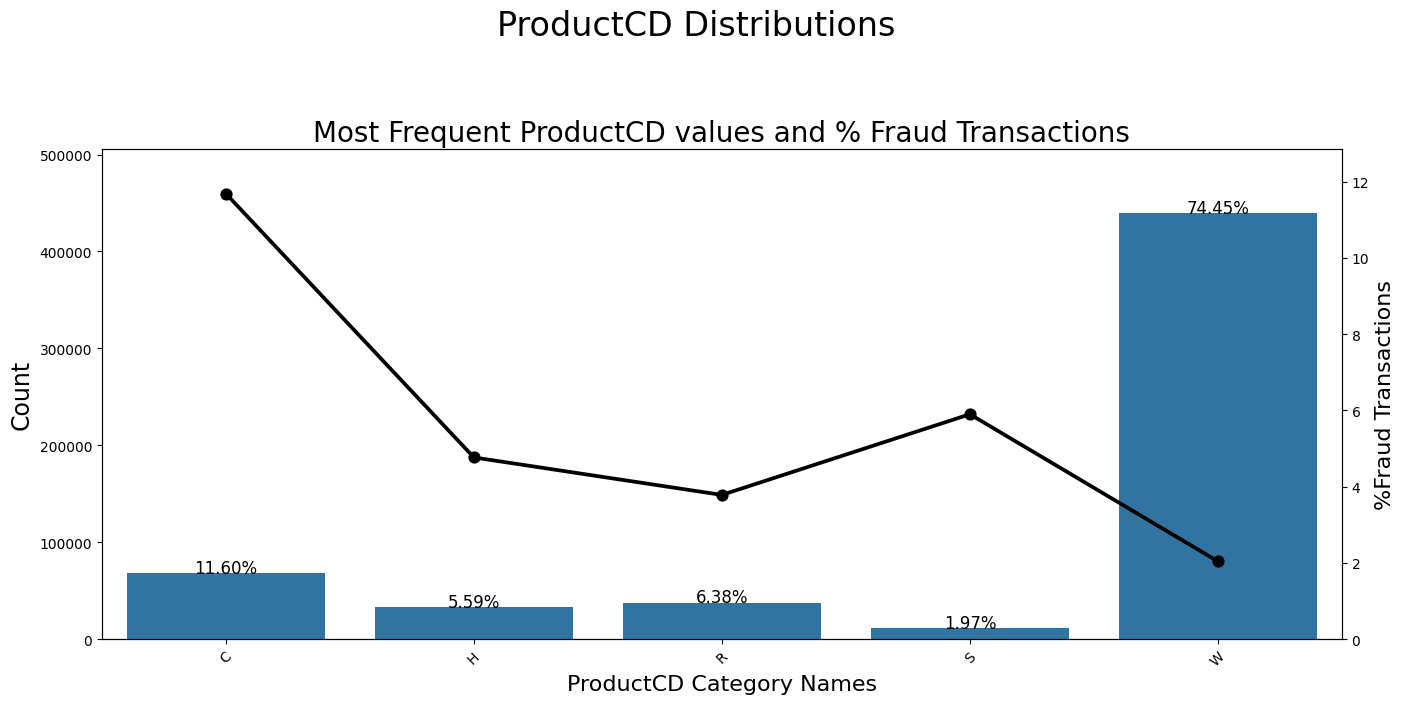

In [21]:
ploting_cnt_amt(train, 'ProductCD')

### addr1 - addr2

* The host of the competition stated that these features are categorical even if they look numerical.


In [22]:
train['addr1'].value_counts().head(10)

299.000    46335
325.000    42751
204.000    42020
264.000    39870
330.000    26287
315.000    23078
441.000    20827
272.000    20141
123.000    16105
126.000    15243
Name: addr1, dtype: int64

In [23]:
train['addr2'].value_counts().head(10)

87.000    520481
60.000      3084
96.000       638
32.000        91
65.000        82
16.000        55
31.000        47
19.000        33
26.000        25
27.000        20
Name: addr2, dtype: int64

In [24]:
train.loc[train['addr1'].isin(train['addr1'].value_counts()[train['addr1'].value_counts() <= 5000 ].index), 'addr1'] = "Others"
train.loc[train['addr2'].isin(train['addr2'].value_counts()[train['addr2'].value_counts() <= 50 ].index), 'addr2'] = "Others"

test.loc[test['addr1'].isin(test.addr1.value_counts()[test['addr1'].value_counts() <= 5000 ].index), 'addr1'] = "Others"
test.loc[test['addr2'].isin(test.addr2.value_counts()[test['addr2'].value_counts() <= 50 ].index), 'addr2'] = "Others"

train['addr1'].fillna("NoInf", inplace=True)
test['addr1'].fillna("NoInf", inplace=True)

train['addr2'].fillna("NoInf", inplace=True)
test['addr2'].fillna("NoInf", inplace=True)

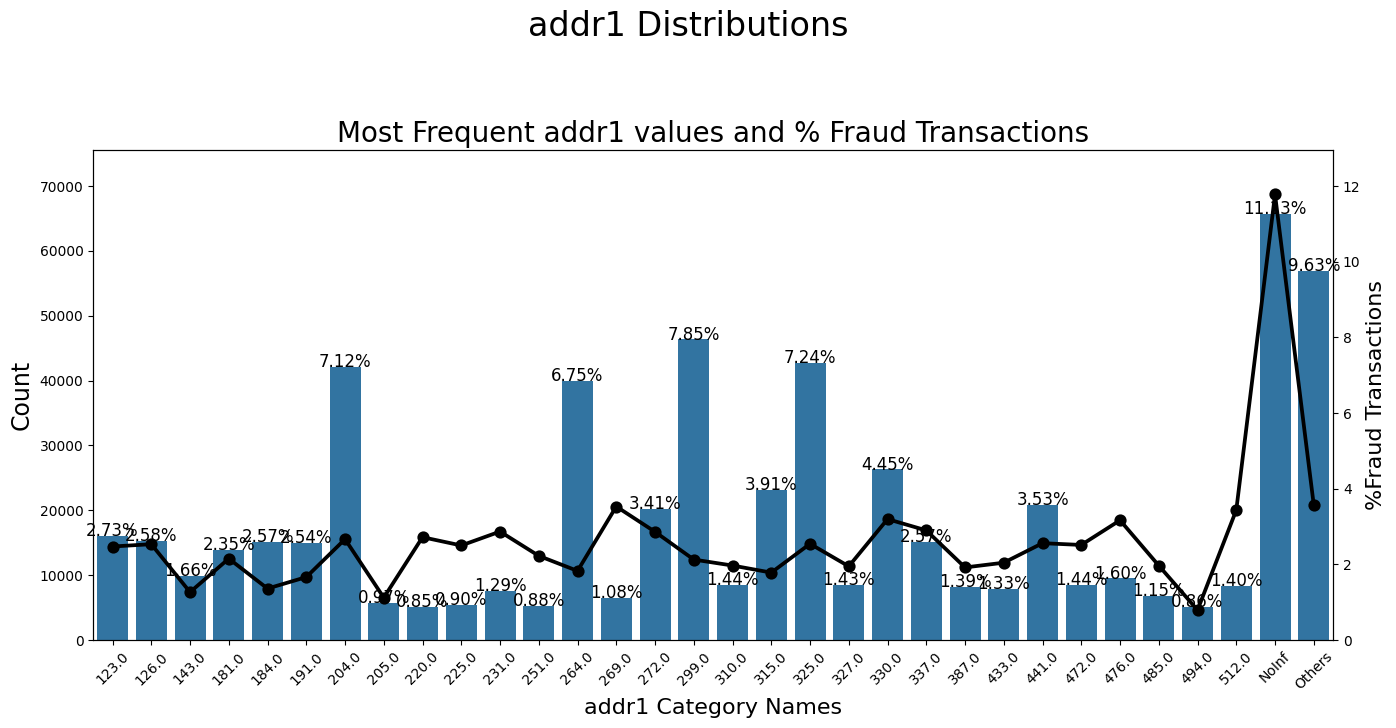

In [25]:
ploting_cnt_amt(train, "addr1")

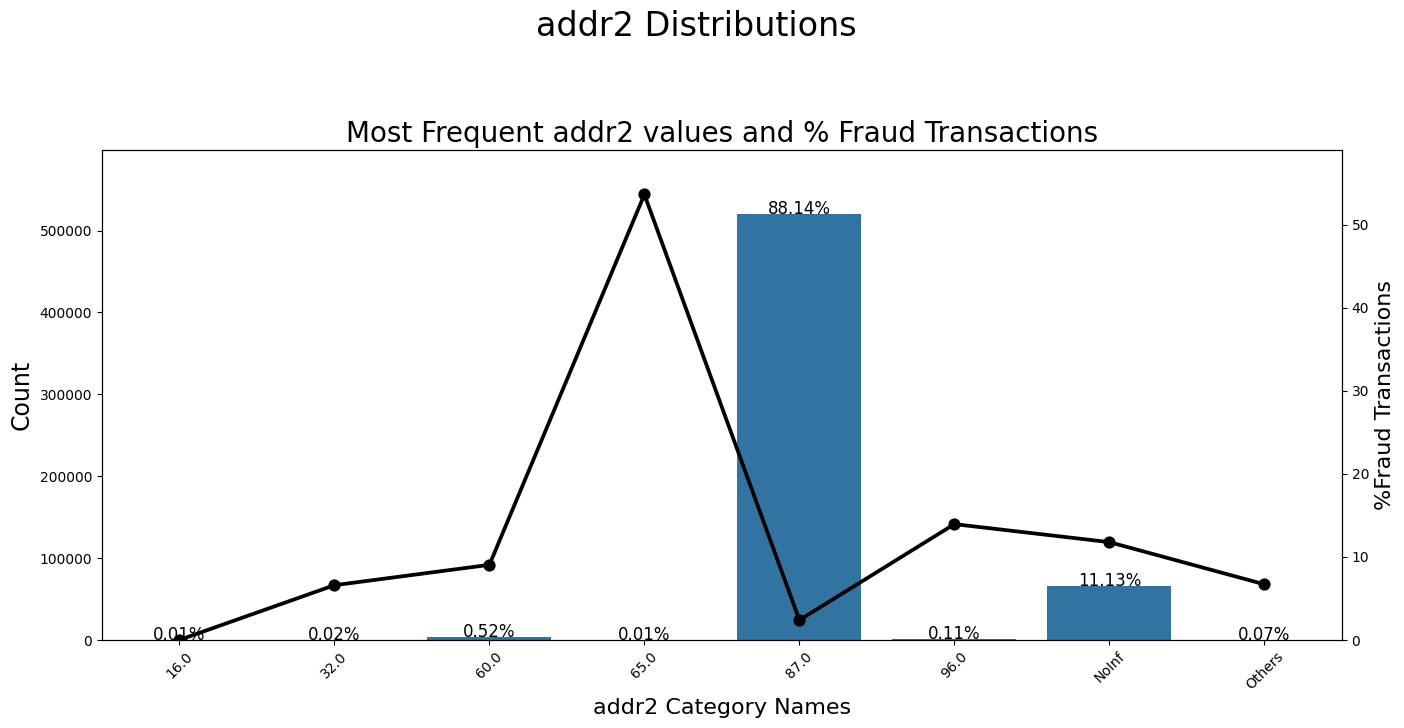

In [26]:
ploting_cnt_amt(train, "addr2")

### P-emaildomain & R-emaildomain

* We can see a very similar distribution in both email domain features.
* We have high values in google and icloud frauds.


### P-emaildomain

* I will group all e-mail domains by the respective enterprises.
* Also, I will set as "Others" all values with less than 500 entries


In [27]:
train['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [28]:
train.loc[train['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

train.loc[train['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
train.loc[train['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx',
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train.loc[train['P_emaildomain'].isin(train['P_emaildomain']\
                                         .value_counts()[train.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train['P_emaildomain'].fillna("NoInf", inplace=True)

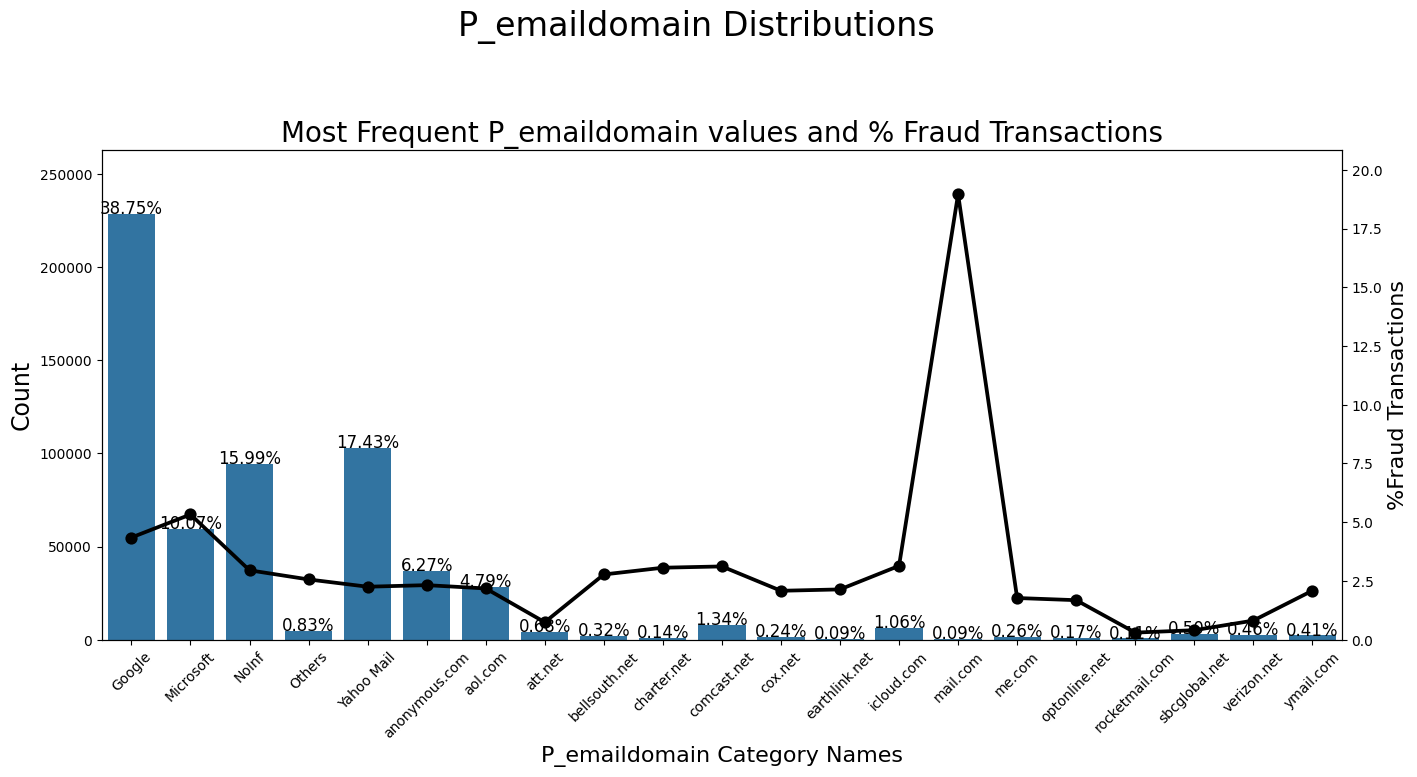

In [29]:
ploting_cnt_amt(train, 'P_emaildomain')

### R-emaildomain

* I will group all e-mail domains by the respective enterprises.
* I will set as "Others" all values with less than 300 entries.


In [30]:
train['R_emaildomain'].value_counts()

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

In [31]:
train.loc[train['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

train.loc[train['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
train.loc[train['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx',
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
train.loc[train['R_emaildomain'].isin(train.R_emaildomain\
                                         .value_counts()[train['R_emaildomain'].value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
train['R_emaildomain'].fillna("NoInf", inplace=True)

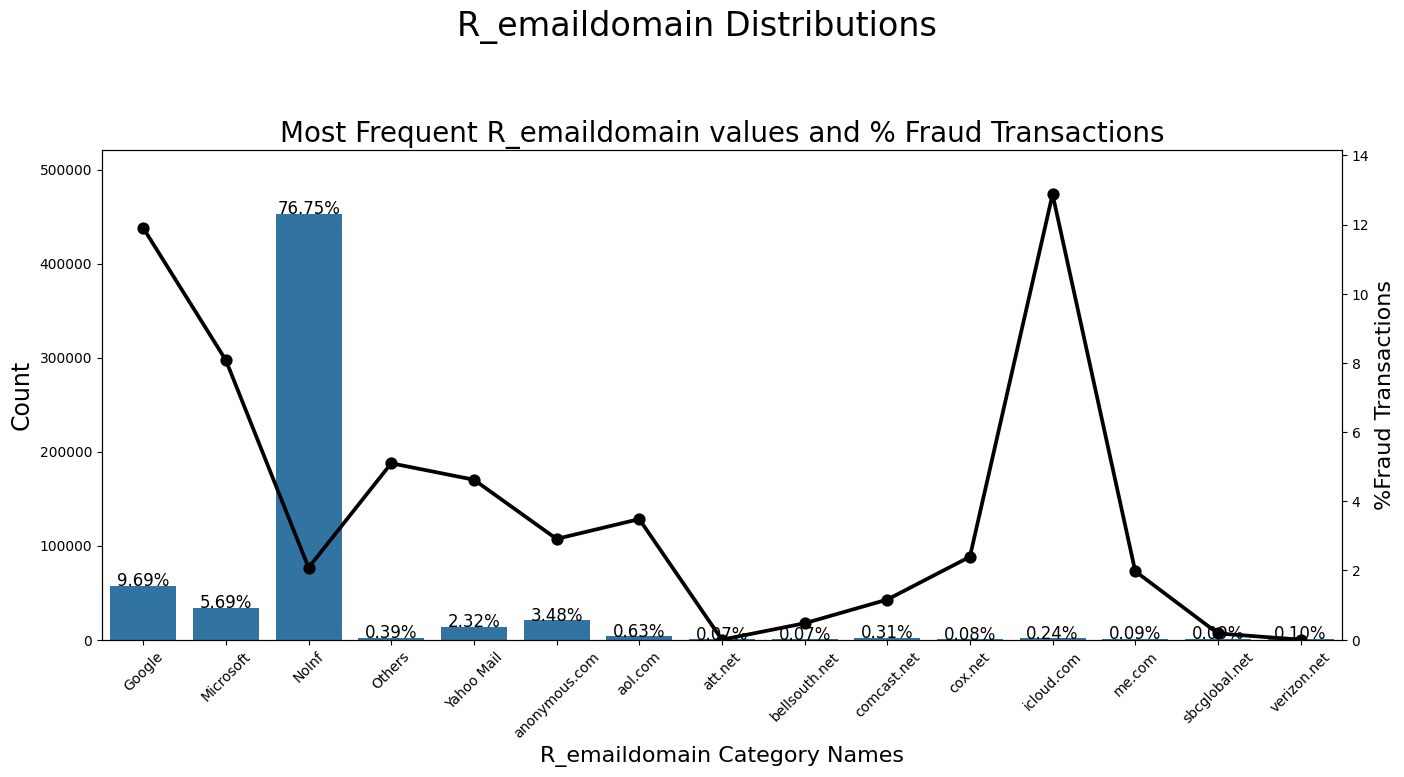

In [32]:
ploting_cnt_amt(train, 'R_emaildomain')

### DeviceType

* Most of the fraudulent transactions were done by the mobile device.



In [33]:
train['DeviceType'].value_counts()

desktop    85165
mobile     55645
Name: DeviceType, dtype: int64

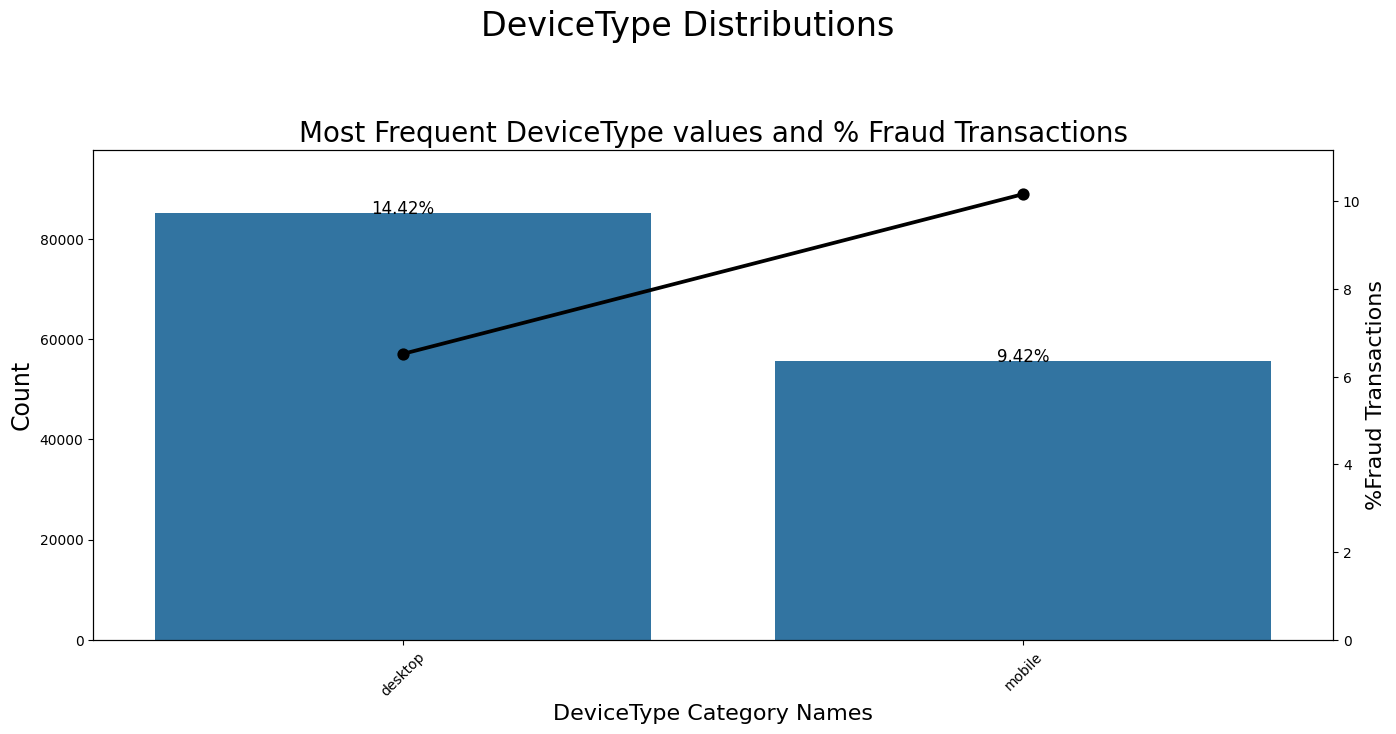

In [34]:
ploting_cnt_amt(train, 'DeviceType')

### DeviceInfo

* Provides information about device names.


In [35]:
train['DeviceInfo'].value_counts()

Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
               ...  
LGMS345            1
verykool           1
XT1072             1
LG-H931            1
0PJA2              1
Name: DeviceInfo, Length: 1786, dtype: int64

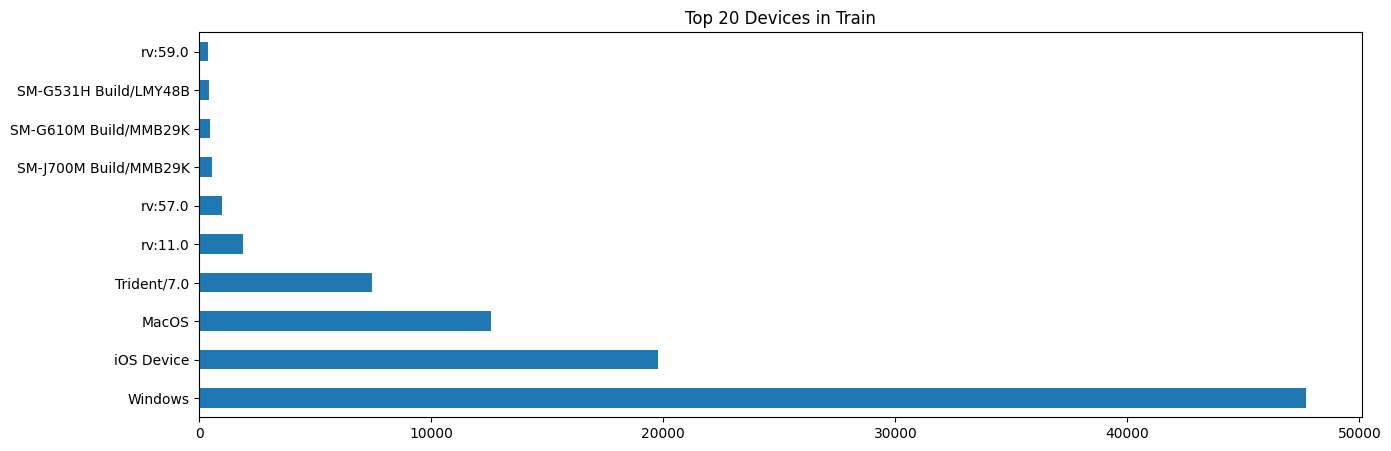

In [36]:
train['DeviceInfo'].value_counts().head(10).plot(kind='barh', figsize=(15, 5), title='Top 20 Devices in Train')
plt.show()

In [37]:
train_test['DeviceInfo'] = train_test['DeviceInfo'].fillna('unknown_device').str.lower()
train_test['DeviceName'] = train_test['DeviceInfo'].str.split('/', expand=True)[0]

train_test.loc[train_test['DeviceName'].str.contains('SM', na=False), 'DeviceName'] = 'Samsung'
train_test.loc[train_test['DeviceName'].str.contains('SAMSUNG', na=False), 'DeviceName'] = 'Samsung'
train_test.loc[train_test['DeviceName'].str.contains('GT-', na=False), 'DeviceName'] = 'Samsung'
train_test.loc[train_test['DeviceName'].str.contains('Moto G', na=False), 'DeviceName'] = 'Motorola'
train_test.loc[train_test['DeviceName'].str.contains('Moto', na=False), 'DeviceName'] = 'Motorola'
train_test.loc[train_test['DeviceName'].str.contains('moto', na=False), 'DeviceName'] = 'Motorola'
train_test.loc[train_test['DeviceName'].str.contains('LG-', na=False), 'DeviceName'] = 'LG'
train_test.loc[train_test['DeviceName'].str.contains('rv:', na=False), 'DeviceName'] = 'RV'
train_test.loc[train_test['DeviceName'].str.contains('HUAWEI', na=False), 'DeviceName'] = 'Huawei'
train_test.loc[train_test['DeviceName'].str.contains('ALE-', na=False), 'DeviceName'] = 'Huawei'
train_test.loc[train_test['DeviceName'].str.contains('-L', na=False), 'DeviceName'] = 'Huawei'
train_test.loc[train_test['DeviceName'].str.contains('Blade', na=False), 'DeviceName'] = 'ZTE'
train_test.loc[train_test['DeviceName'].str.contains('BLADE', na=False), 'DeviceName'] = 'ZTE'
train_test.loc[train_test['DeviceName'].str.contains('Linux', na=False), 'DeviceName'] = 'Linux'
train_test.loc[train_test['DeviceName'].str.contains('XT', na=False), 'DeviceName'] = 'Sony'
train_test.loc[train_test['DeviceName'].str.contains('HTC', na=False), 'DeviceName'] = 'HTC'
train_test.loc[train_test['DeviceName'].str.contains('ASUS', na=False), 'DeviceName'] = 'Asus'

train_test.loc[train_test['DeviceName'].isin(train_test['DeviceName'].value_counts()[train_test['DeviceName'].value_counts() < 1000].index), 'DeviceName'] = "Others"

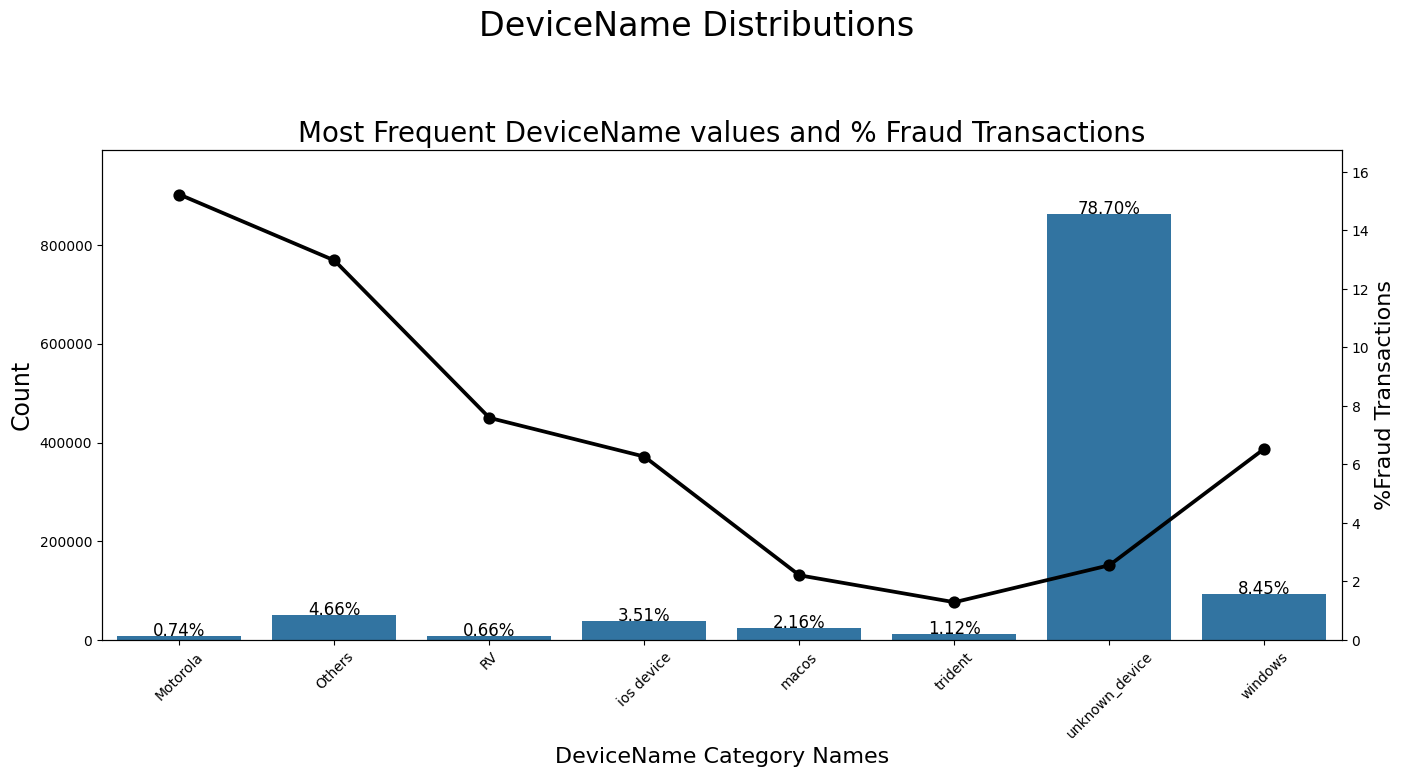

In [38]:
ploting_cnt_amt(train_test, 'DeviceName')

## Exploring Group Features (card, C, D, M, V, id )

## card1-card6

* The host of the competition stated that some of the features are categorical even if they look numerical like card features.
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* card4 and card6 have 4 unique values, and the others more than 100
* Except card1, card features have nan values ​​so I will group them according to card1 and fill with the most common value.



In [39]:
card_cols = [c for c in train.columns if 'card' in c]
train[card_cols].head()

card1   card2   card3       card4   card5   card6
0  13926     NaN 150.000    discover 142.000  credit
1   2755 404.000 150.000  mastercard 102.000  credit
2   4663 490.000 150.000        visa 166.000   debit
3  18132 567.000 150.000  mastercard 117.000   debit
4   4497 514.000 150.000  mastercard 102.000  credit

In [40]:
train_test[card_cols].isnull().sum()

card1        0
card2    17587
card3     4567
card4     4663
card5     8806
card6     4578
dtype: int64

In [41]:
for col in card_cols:
    print(col+'  :' + str(train[col].nunique()))

card1  :13553
card2  :500
card3  :114
card4  :4
card5  :119
card6  :4


In [42]:
for col in ['card2','card3','card4','card5','card6']:
    train_test[col] = train_test.groupby(['card1'])[col].transform(lambda x: x.mode(dropna=False).iat[0])
    train_test[col].fillna(train_test[col].mode()[0], inplace=True)
    print(col+' has : '+str(train_test[col].isnull().sum())+' missing values')

card2 has : 0 missing values
card3 has : 0 missing values
card4 has : 0 missing values
card5 has : 0 missing values
card6 has : 0 missing values


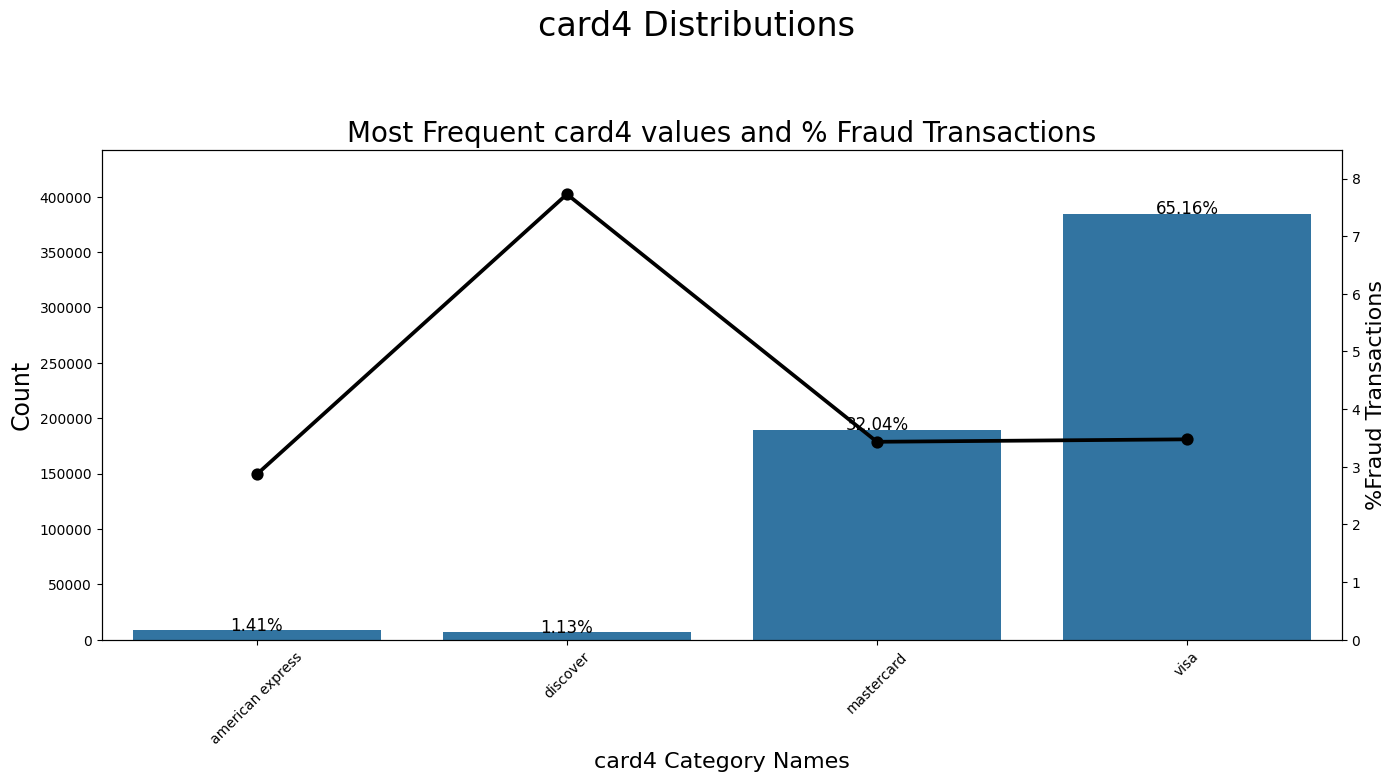

In [43]:
ploting_cnt_amt(train, 'card4')

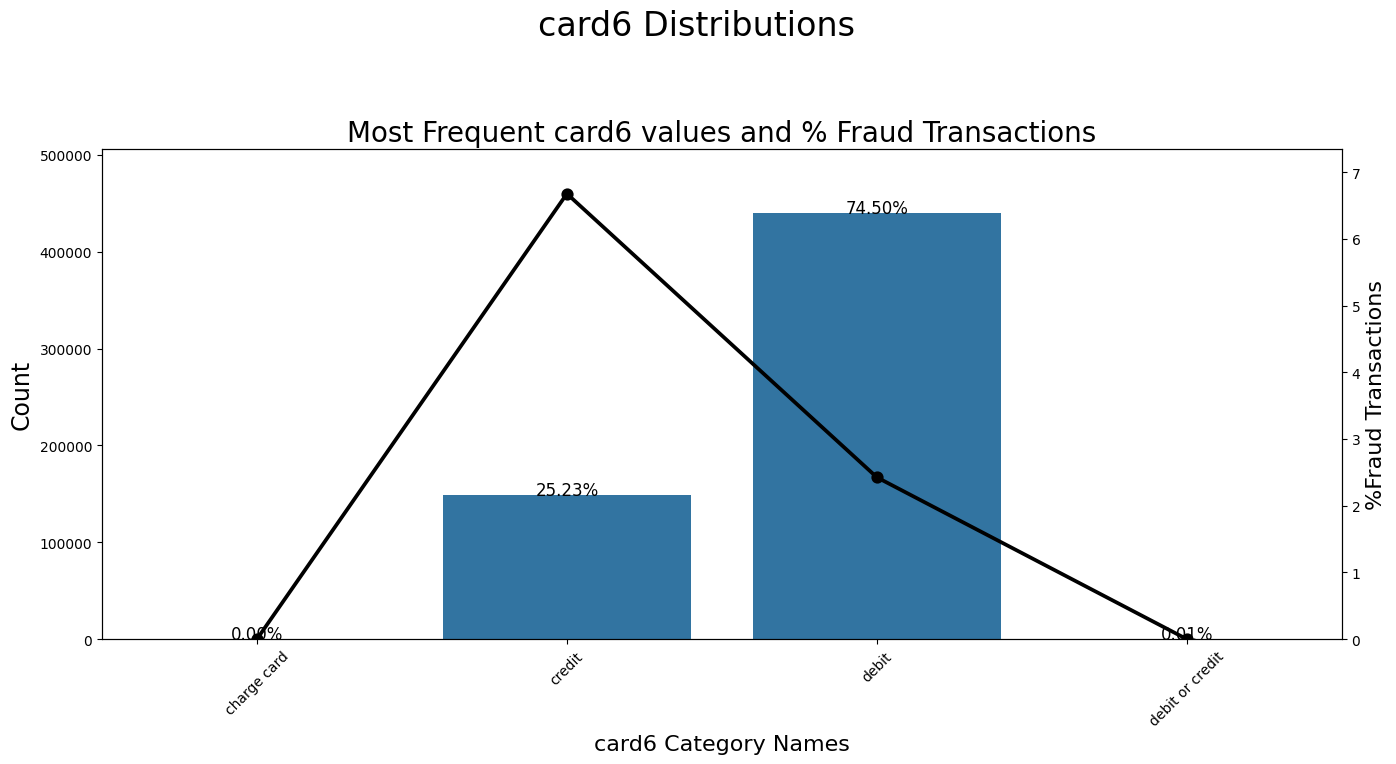

In [44]:
ploting_cnt_amt(train, 'card6')

### C1-C14

* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is 0masked.
* All of the C features are continuous.


In [45]:
c_cols = [c for c in train if c[0] == 'C']
train[c_cols].head()

C1    C2    C3    C4    C5    C6    C7    C8    C9   C10   C11   C12  \
0 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 2.000 0.000   
1 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 1.000 0.000   
2 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000   
3 2.000 5.000 0.000 0.000 0.000 4.000 0.000 0.000 1.000 0.000 1.000 0.000   
4 1.000 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000   

     C13   C14  
0  1.000 1.000  
1  1.000 1.000  
2  1.000 1.000  
3 25.000 1.000  
4  1.000 1.000

In [46]:
train[c_cols].describe()

C1         C2         C3         C4         C5         C6  \
count 590540.000 590540.000 590540.000 590540.000 590540.000 590540.000   
mean      14.092     15.270      0.006      4.092      5.572      9.071   
std      133.567    154.668      0.151     68.848     25.787     71.508   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      0.000      0.000      0.000      1.000   
50%        1.000      1.000      0.000      0.000      0.000      1.000   
75%        3.000      3.000      0.000      0.000      1.000      2.000   
max     4684.000   5692.000     26.000   2252.000    349.000   2252.000   

              C7         C8         C9        C10        C11        C12  \
count 590540.000 590540.000 590540.000 590540.000 590540.000 590540.000   
mean       2.848      5.145      4.480      5.240     10.242      4.076   
std       61.727     95.378     16.675     95.581     94.337     86.667   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.000      0.000      0.000      0.000      1.000      0.000   
50%        0.000      0.000      1.000      0.000      1.000      0.000   
75%        0.000      0.000      2.000      0.000      2.000      0.000   
max     2256.000   3332.000    210.000   3256.000   3188.000   3188.000   

             C13        C14  
count 590540.000 590540.000  
mean      32.540      8.295  
std      129.365     49.544  
min        0.000      0.000  
25%        1.000      1.000  
50%        3.000      1.000  
75%       12.000      2.000  
max     2918.000   1429.000

In [47]:
train[c_cols].quantile([.01, .1, .25, .5, .75, .9, .99])

C1      C2    C3    C4      C5      C6    C7     C8     C9    C10  \
0.010   1.000   1.000 0.000 0.000   0.000   0.000 0.000  0.000  0.000  0.000   
0.100   1.000   1.000 0.000 0.000   0.000   1.000 0.000  0.000  0.000  0.000   
0.250   1.000   1.000 0.000 0.000   0.000   1.000 0.000  0.000  0.000  0.000   
0.500   1.000   1.000 0.000 0.000   0.000   1.000 0.000  0.000  1.000  0.000   
0.750   3.000   3.000 0.000 0.000   1.000   2.000 0.000  0.000  2.000  0.000   
0.900   7.000   7.000 0.000 1.000   3.000   5.000 1.000  1.000  4.000  1.000   
0.990 164.000 154.000 0.000 6.000 149.000 118.000 4.000 11.000 95.000 15.000   

          C11   C12     C13     C14  
0.010   1.000 0.000   0.000   0.000  
0.100   1.000 0.000   1.000   1.000  
0.250   1.000 0.000   1.000   1.000  
0.500   1.000 0.000   3.000   1.000  
0.750   2.000 0.000  12.000   2.000  
0.900   4.000 1.000  37.000   5.000  
0.990 122.000 5.000 578.000 128.000

In [48]:
# train[train['C6']>118.000]['isFraud'].mean()

for col in c_cols:
    print('\n Fraud '+col+' mean    :  '+str(train_fraud[train_fraud[col]<=37.00][col].mean()))
    print(' Non - Fraud '+col+' mean:  '+str(train_non_fraud[train_non_fraud[col]<=37.00][col].mean()))


 Fraud C1 mean    :  4.2571244
 Non - Fraud C1 mean:  2.31699

 Fraud C2 mean    :  4.463068
 Non - Fraud C2 mean:  2.3609915

 Fraud C3 mean    :  0.00024197841
 Non - Fraud C3 mean:  0.005839857

 Fraud C4 mean    :  1.9088897
 Non - Fraud C4 mean:  0.29581532

 Fraud C5 mean    :  0.25842533
 Non - Fraud C5 mean:  0.82222116

 Fraud C6 mean    :  2.8822572
 Non - Fraud C6 mean:  1.7692126

 Fraud C7 mean    :  1.5139704
 Non - Fraud C7 mean:  0.14242142

 Fraud C8 mean    :  2.2721825
 Non - Fraud C8 mean:  0.3941835

 Fraud C9 mean    :  0.9496262
 Non - Fraud C9 mean:  1.4323556

 Fraud C10 mean    :  2.1024442
 Non - Fraud C10 mean:  0.38707665

 Fraud C11 mean    :  3.2034557
 Non - Fraud C11 mean:  1.793764

 Fraud C12 mean    :  1.8384278
 Non - Fraud C12 mean:  0.22609805

 Fraud C13 mean    :  4.0394764
 Non - Fraud C13 mean:  5.9857965

 Fraud C14 mean    :  1.8908032
 Non - Fraud C14 mean:  2.0093317


### D1-D15

* The D Columns are "time deltas" from some point in the past.


In [49]:
d_cols = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14']
train[d_cols].head()

D1      D2     D3     D4    D5  D6  D7  D8  D9    D10     D11  D12  \
0  14.000     NaN 13.000    NaN   NaN NaN NaN NaN NaN 13.000  13.000  NaN   
1   0.000     NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000     NaN  NaN   
2   0.000     NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000 315.000  NaN   
3 112.000 112.000  0.000 94.000 0.000 NaN NaN NaN NaN 84.000     NaN  NaN   
4   0.000     NaN    NaN    NaN   NaN NaN NaN NaN NaN    NaN     NaN  NaN   

   D13  D14  
0  NaN  NaN  
1  NaN  NaN  
2  NaN  NaN  
3  NaN  NaN  
4  NaN  NaN

In [50]:
train[d_cols].describe()

D1         D2         D3         D4         D5        D6  \
count 589271.000 309743.000 327662.000 421618.000 280699.000 73187.000   
mean      94.348    169.563     28.343    140.002     42.336    69.806   
std      157.660    177.316     62.385    191.097     89.000   143.669   
min        0.000      0.000      0.000   -122.000      0.000   -83.000   
25%        0.000     26.000      1.000      0.000      1.000     0.000   
50%        3.000     97.000      8.000     26.000     10.000     0.000   
75%      122.000    276.000     27.000    253.000     32.000    40.000   
max      640.000    640.000    819.000    869.000    819.000   873.000   

             D7        D8        D9        D10        D11       D12       D13  \
count 38917.000 74926.000 74926.000 514518.000 311253.000 64717.000 61952.000   
mean     41.639   146.060     0.561    123.982    146.621    54.038    17.901   
std      99.743   231.672     0.317    182.615    186.043   124.275    67.614   
min       0.000     0.000     0.000      0.000    -53.000   -83.000     0.000   
25%       0.000     0.958     0.208      0.000      0.000     0.000     0.000   
50%       0.000    37.875     0.667     15.000     43.000     0.000     0.000   
75%      17.000   188.000     0.833    197.000    274.000    13.000     0.000   
max     843.000  1708.000     0.958    876.000    670.000   648.000   847.000   

            D14  
count 62187.000  
mean     57.724  
std     136.312  
min    -193.000  
25%       0.000  
50%       0.000  
75%       2.000  
max     878.000

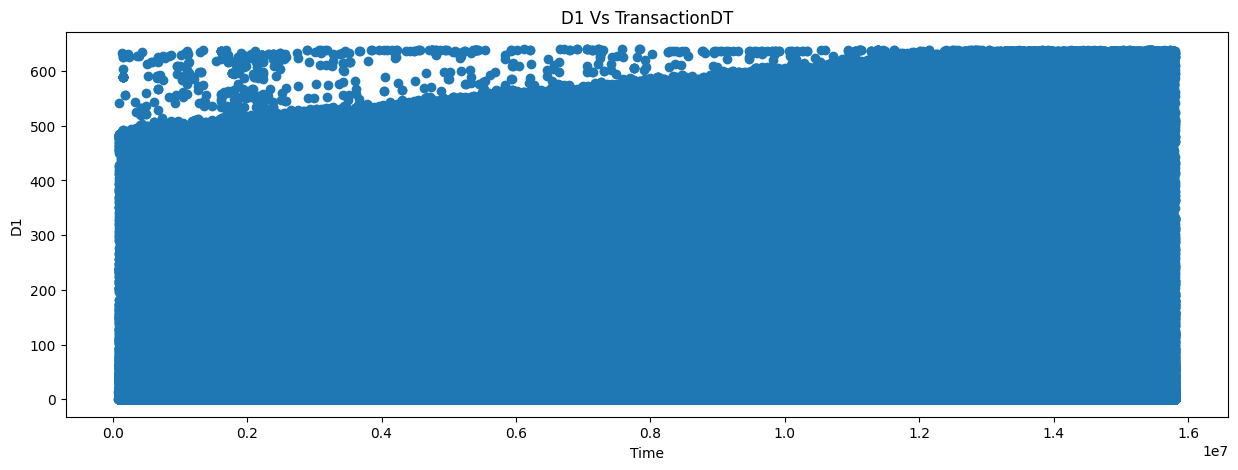

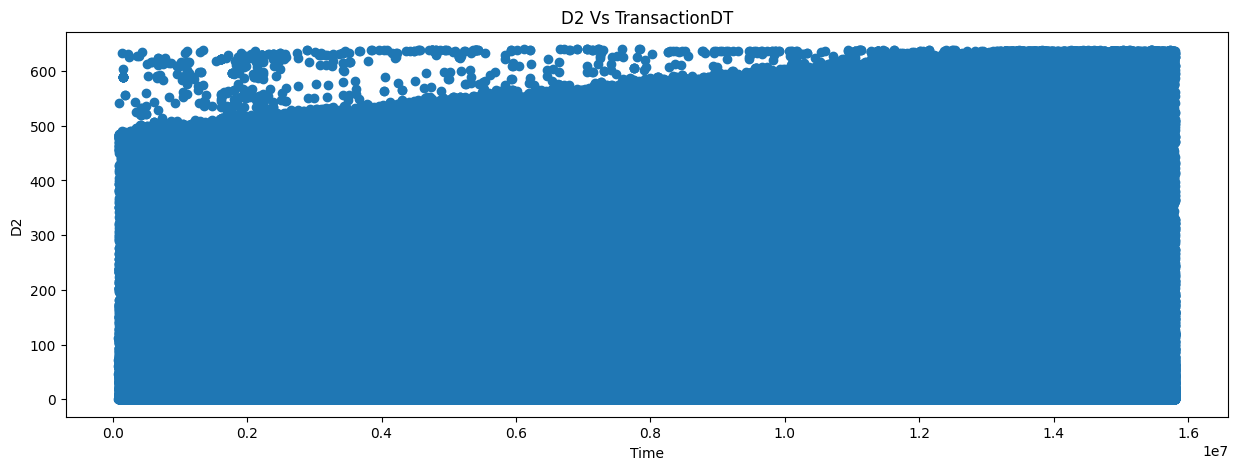

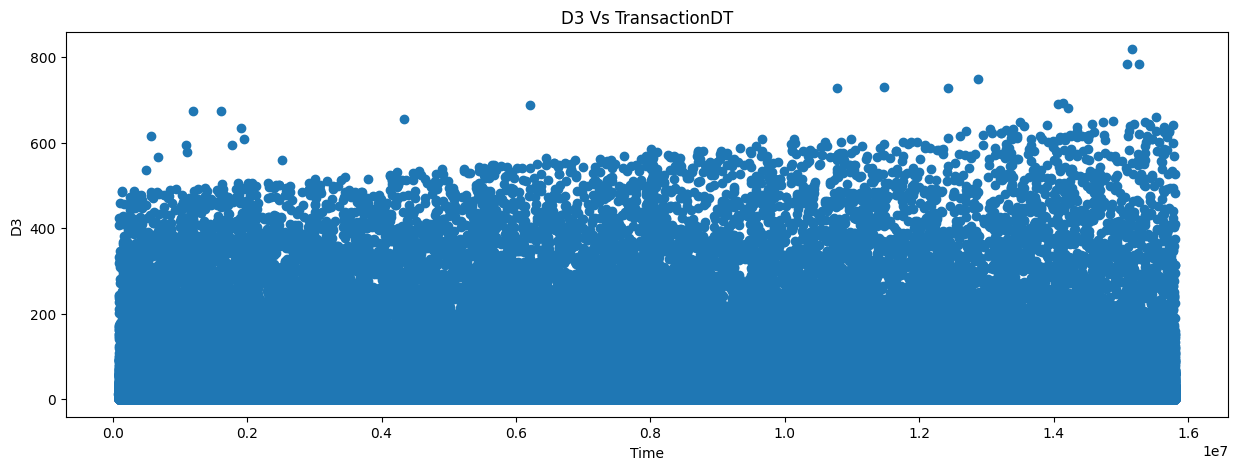

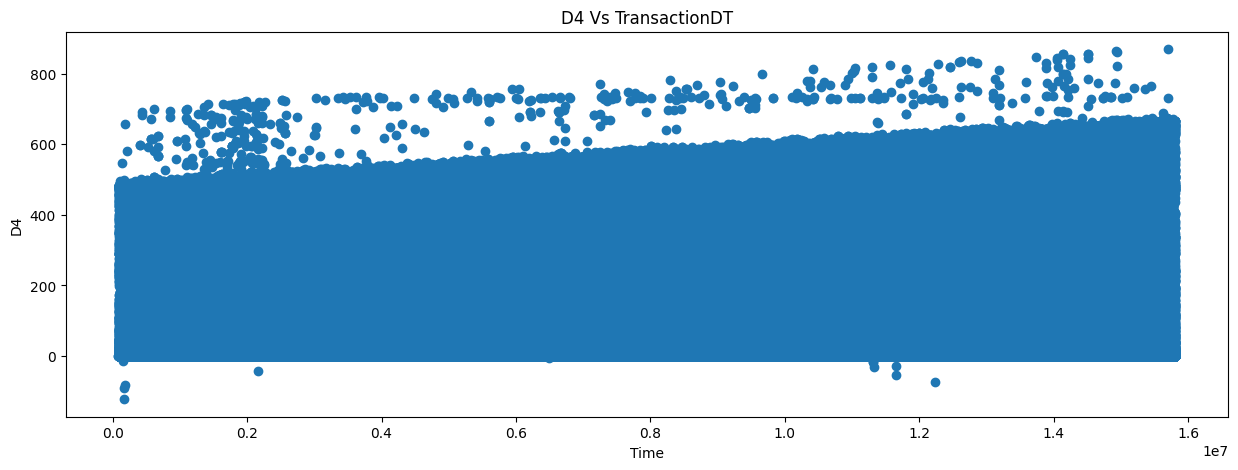

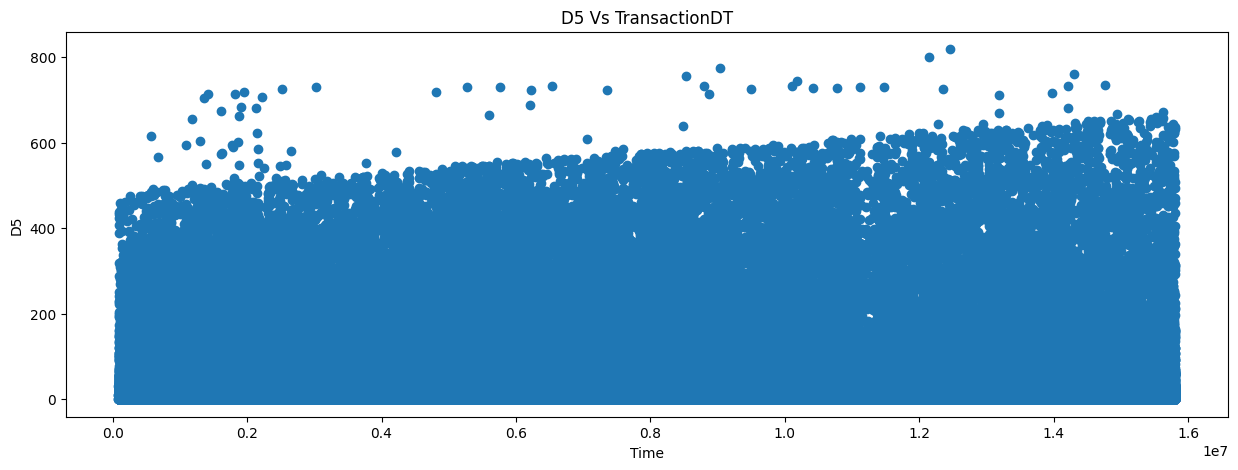

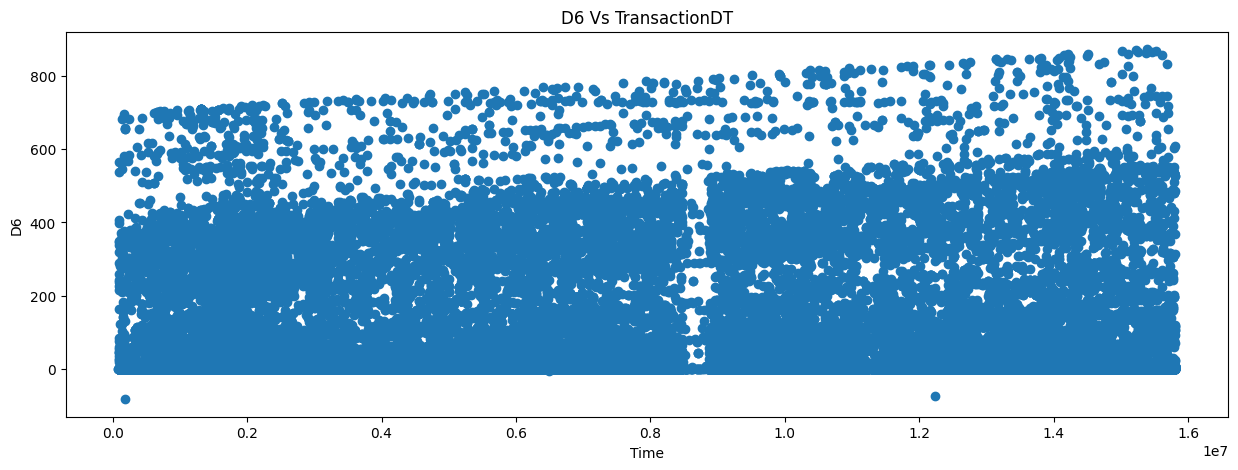

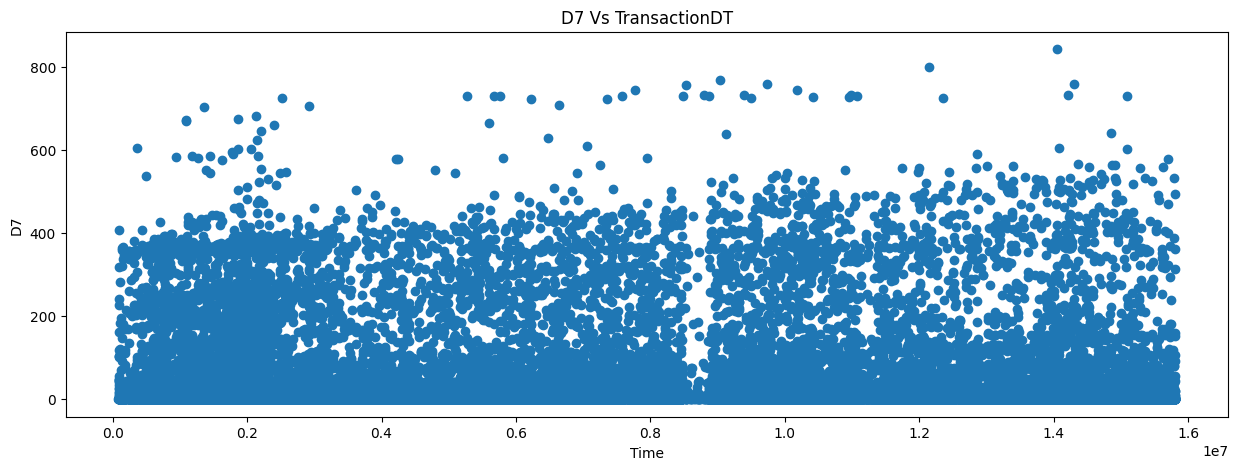

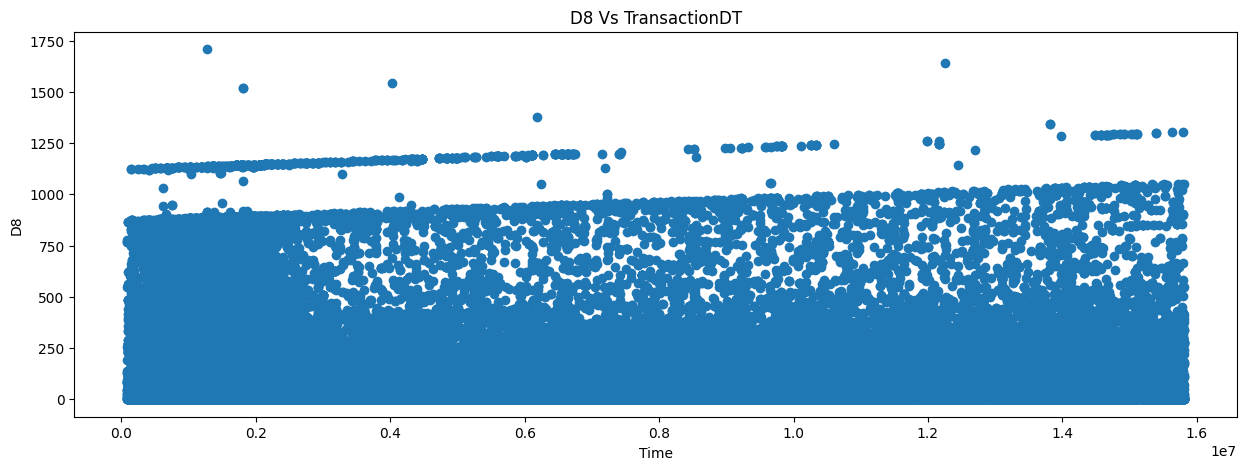

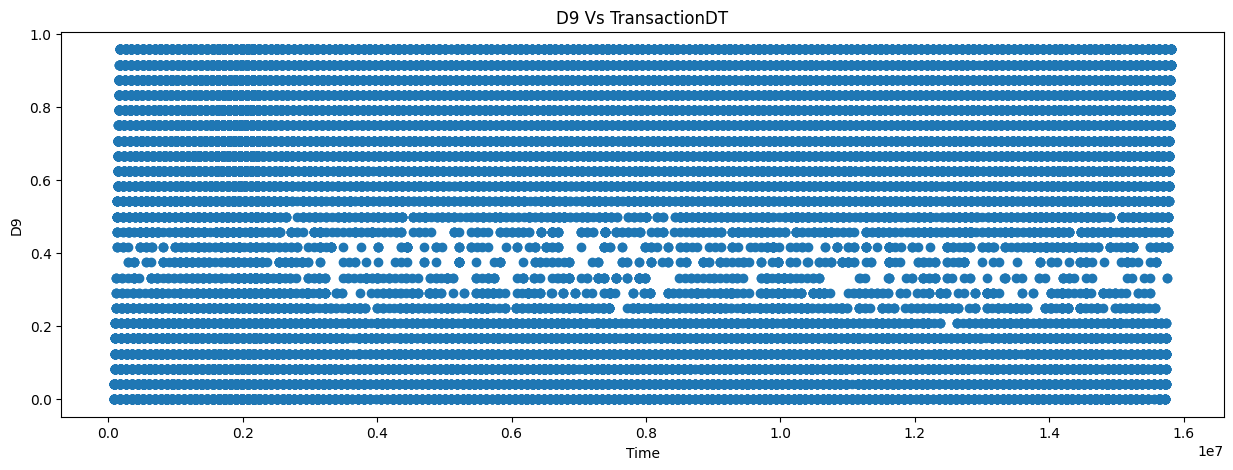

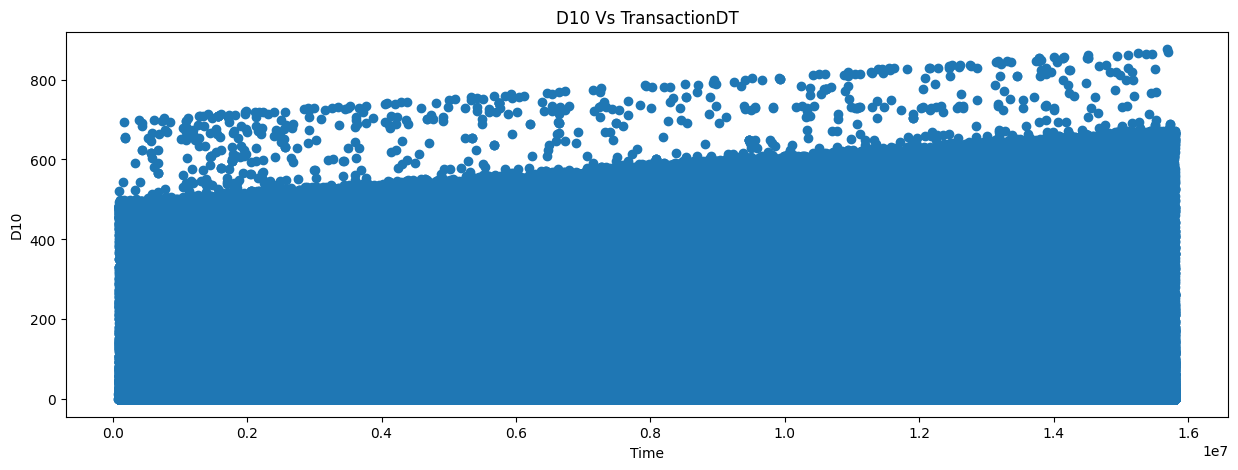

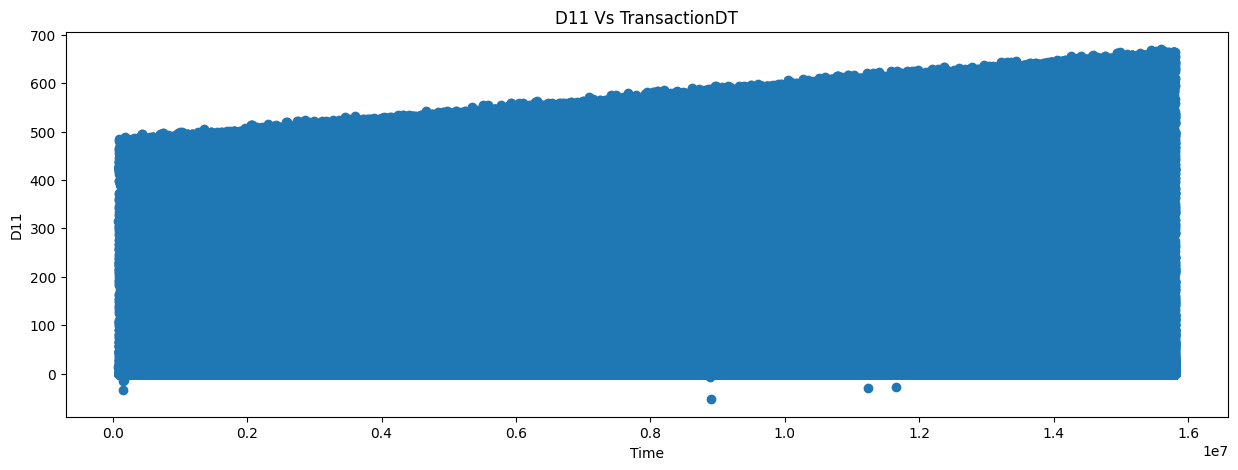

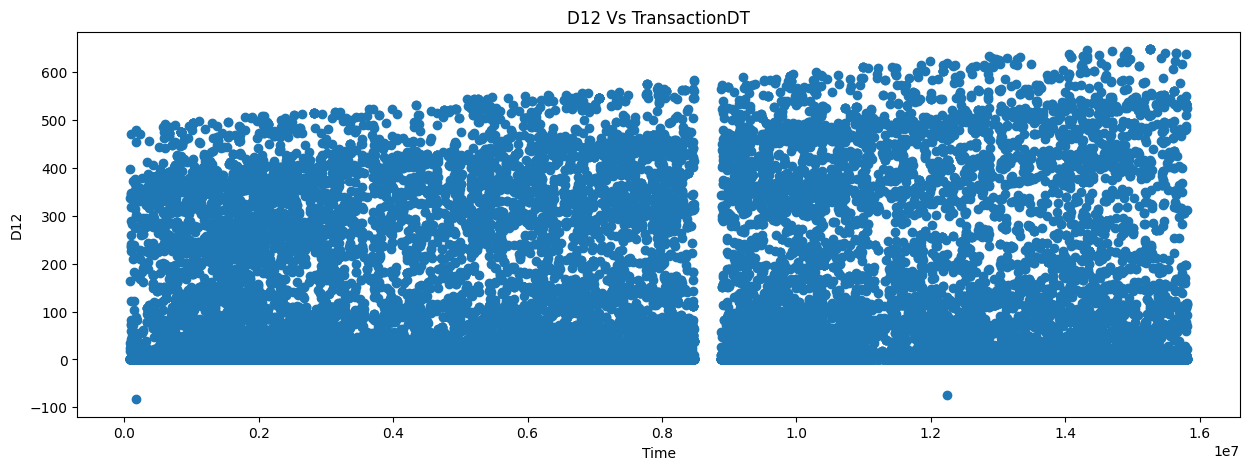

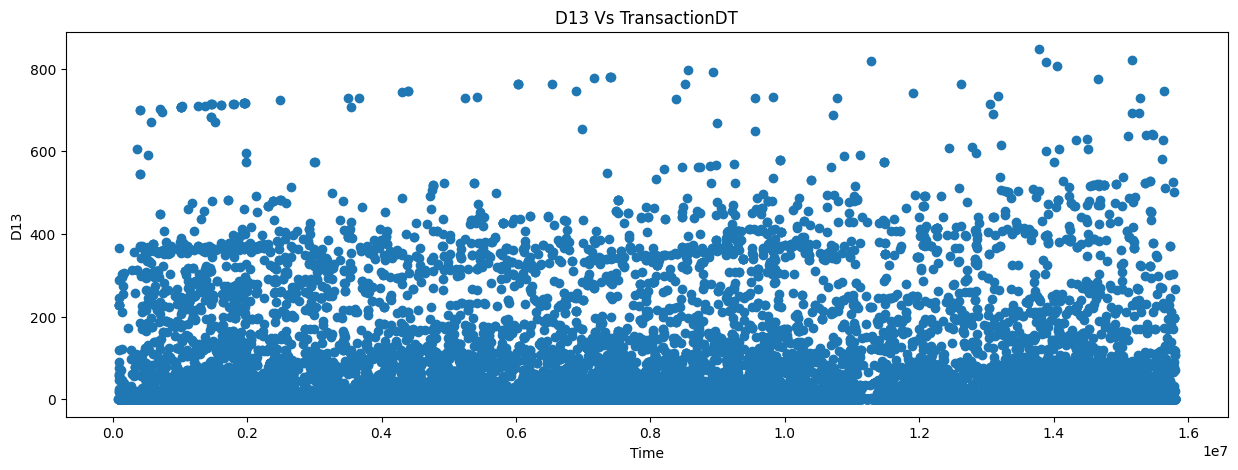

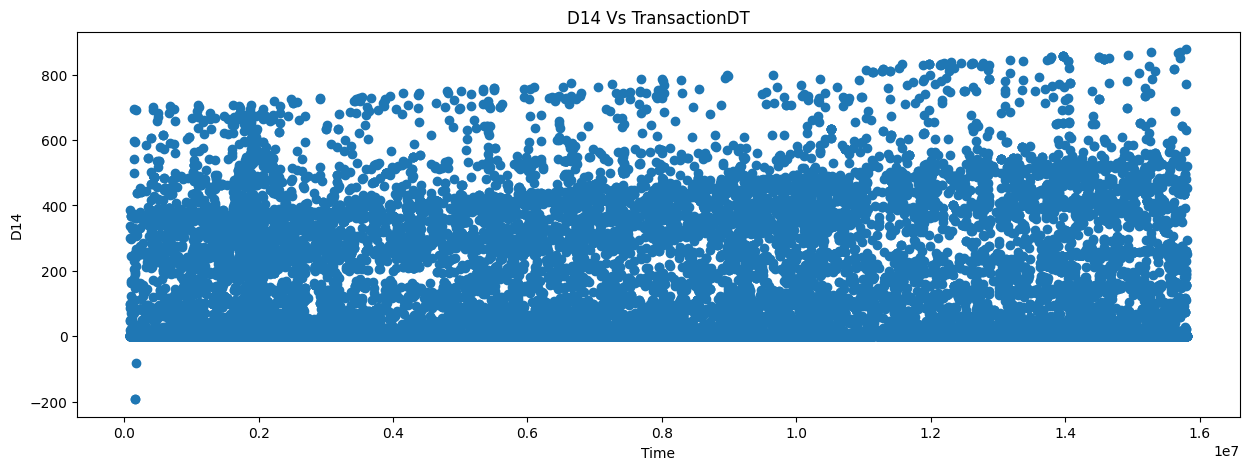

In [51]:
for col in d_cols:
    plt.figure(figsize=(15,5))
    plt.scatter(train['TransactionDT'] ,train[col])
    plt.title(col + ' Vs TransactionDT')
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.show()

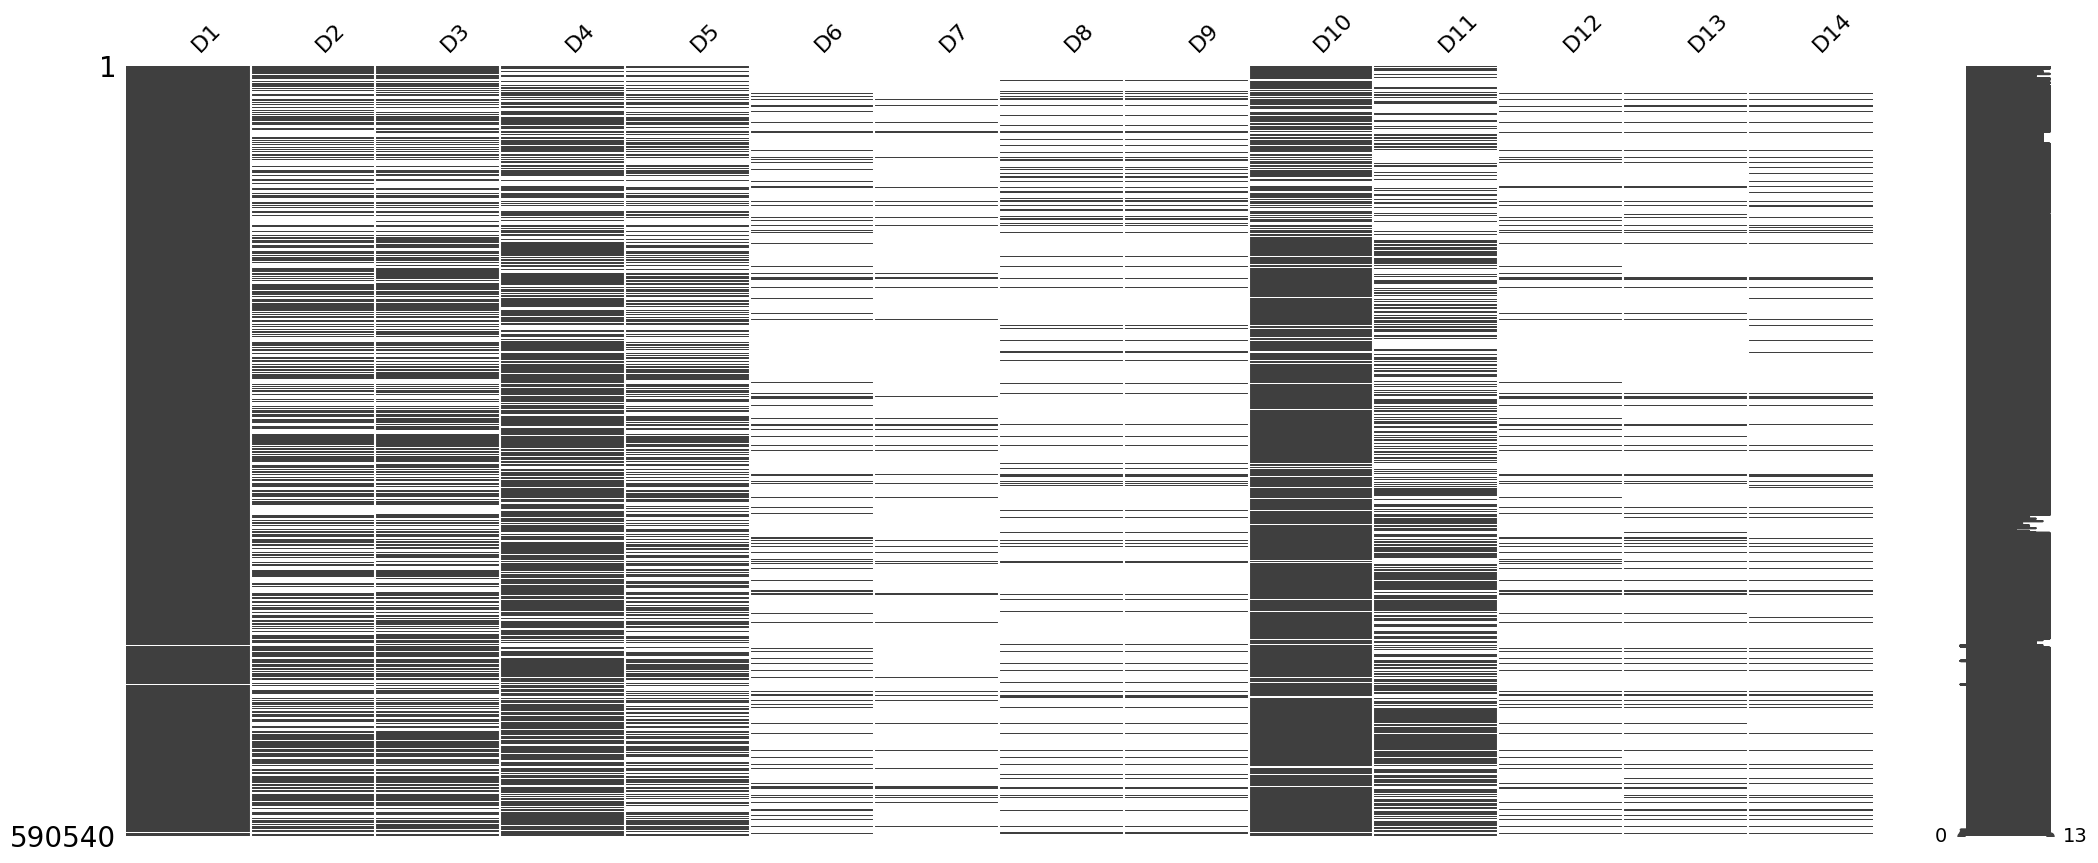

In [52]:
msno.matrix(train[d_cols]);

### M1-M9

* M1-M9 : match, such as names on card and address, etc.
* All of the M features are categorical.
* Values are T F or NaN except M4.
* M4 feature appears to be different from others.


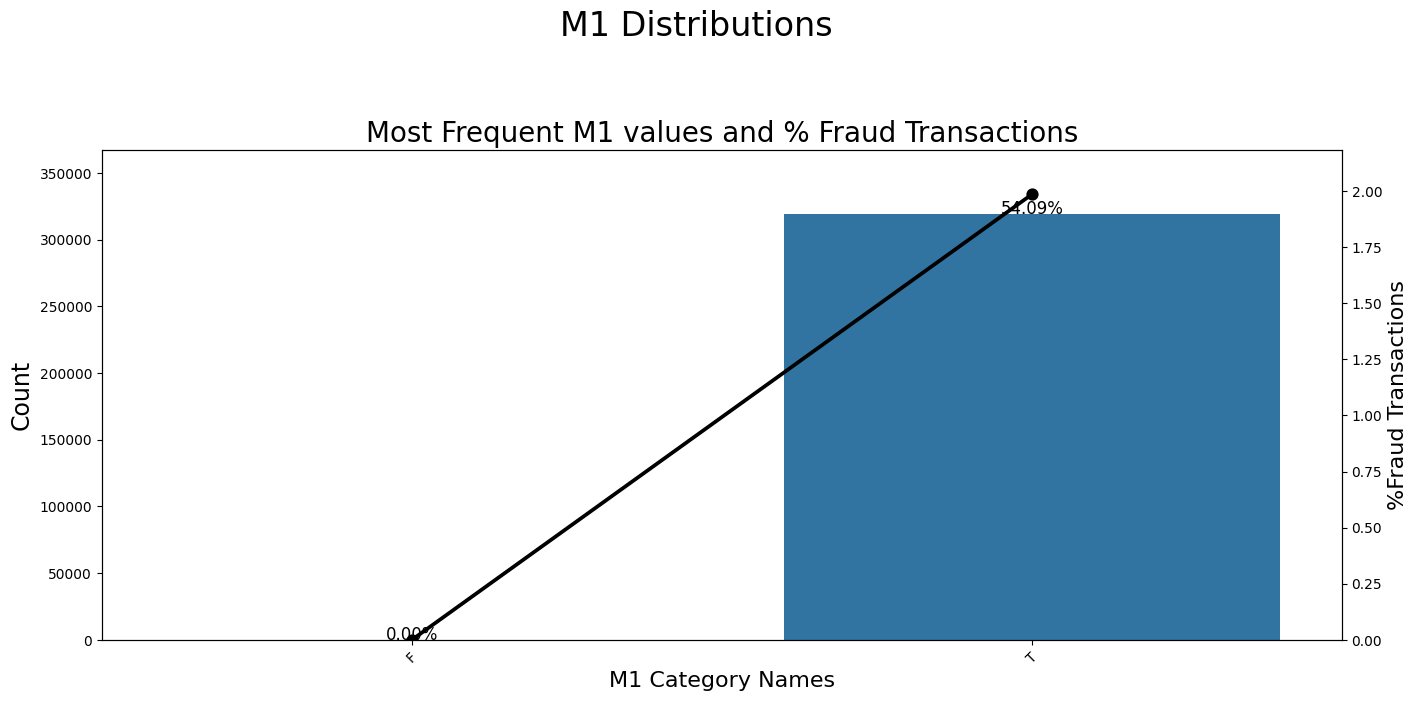

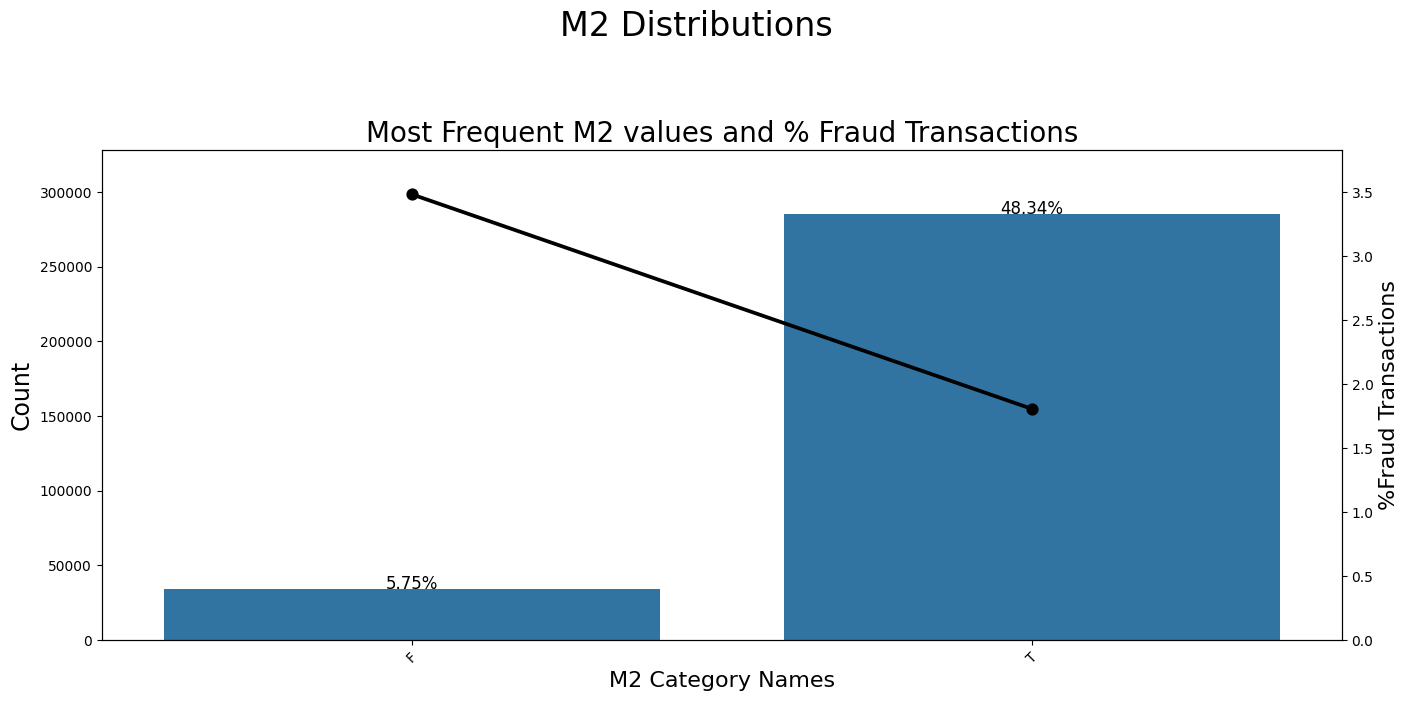

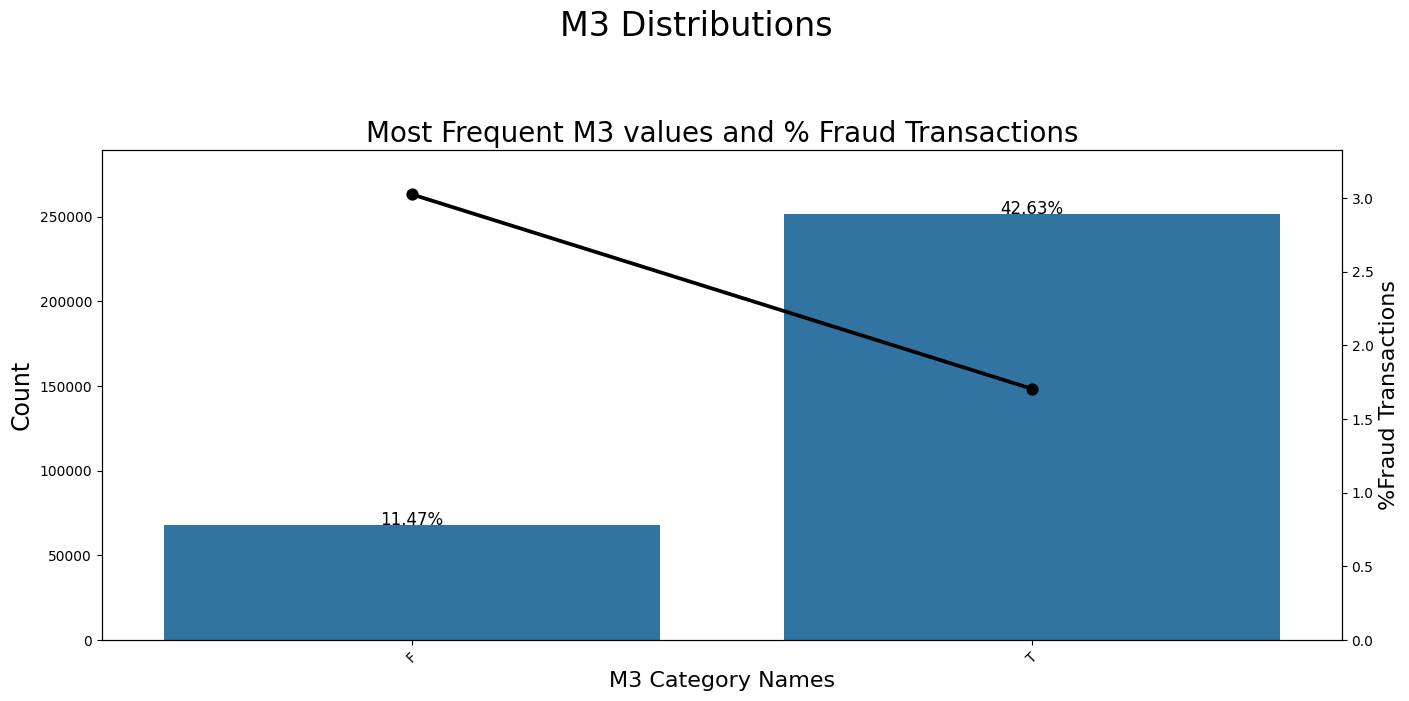

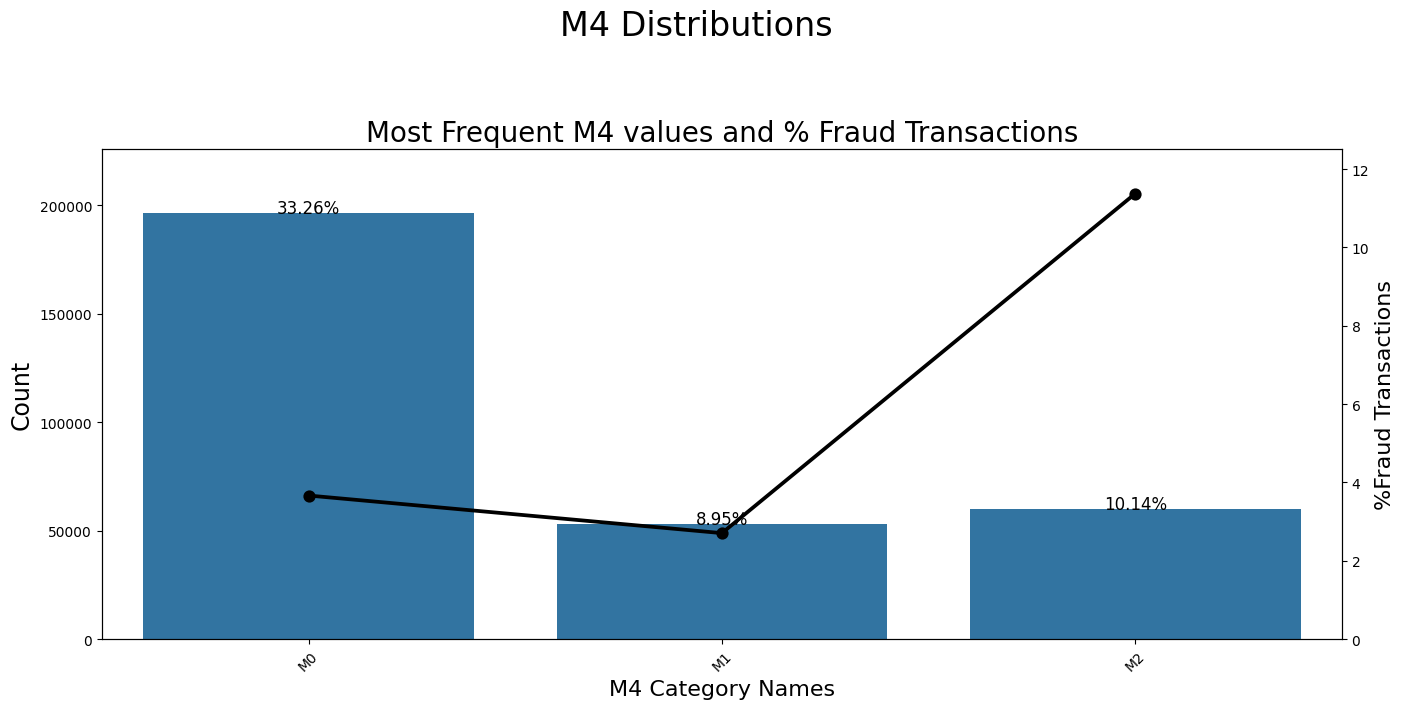

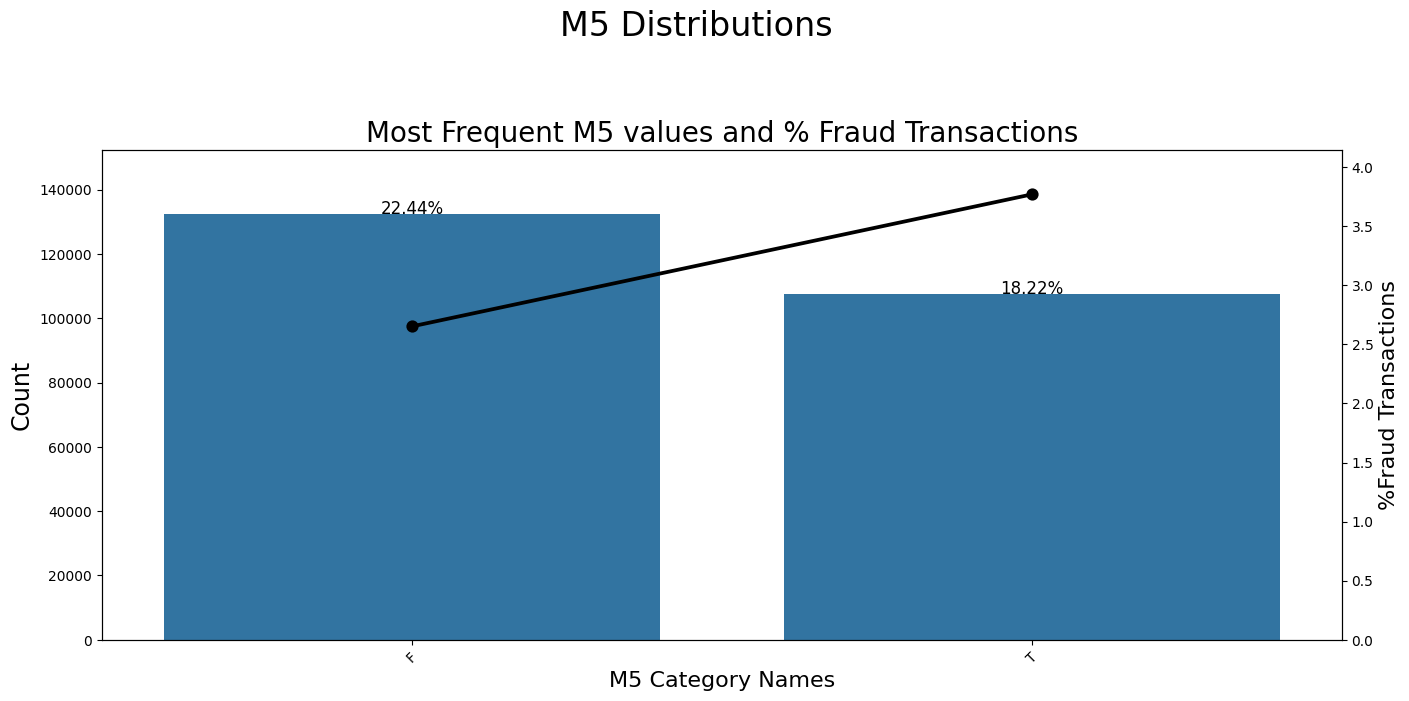

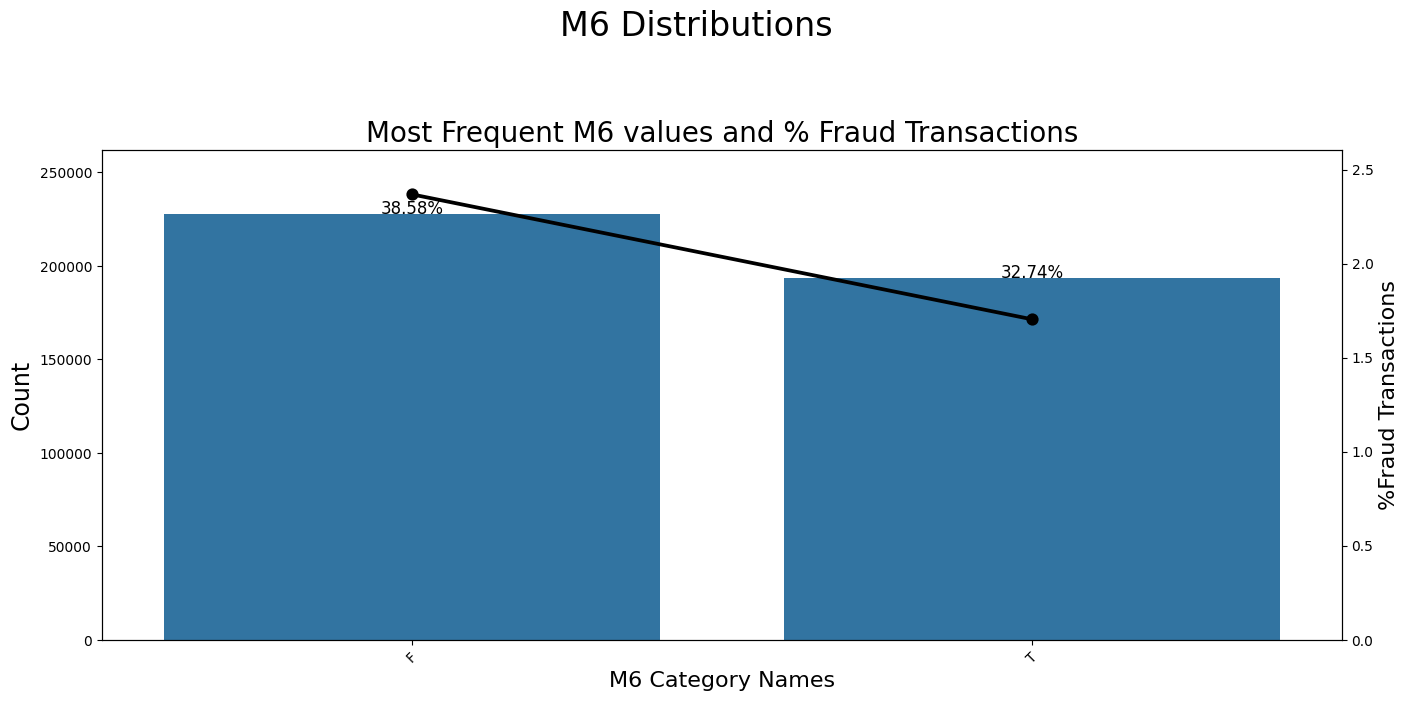

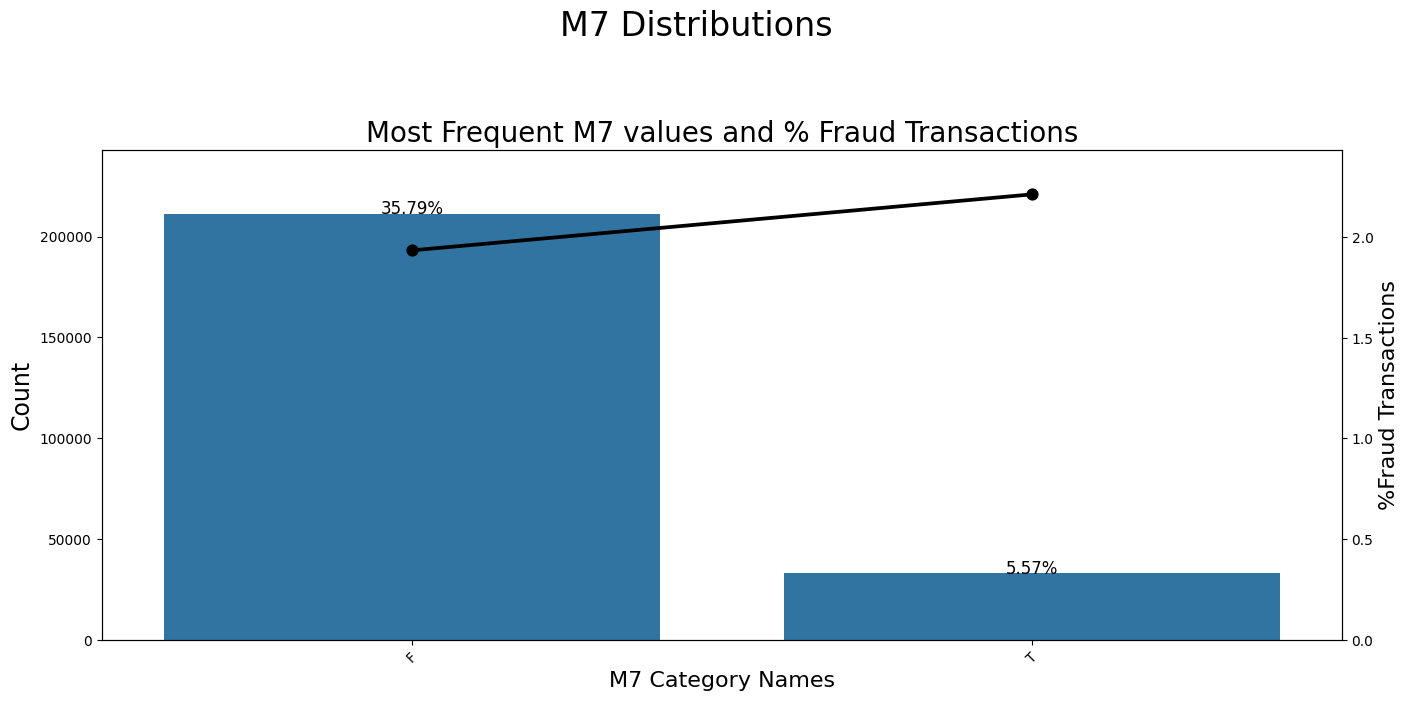

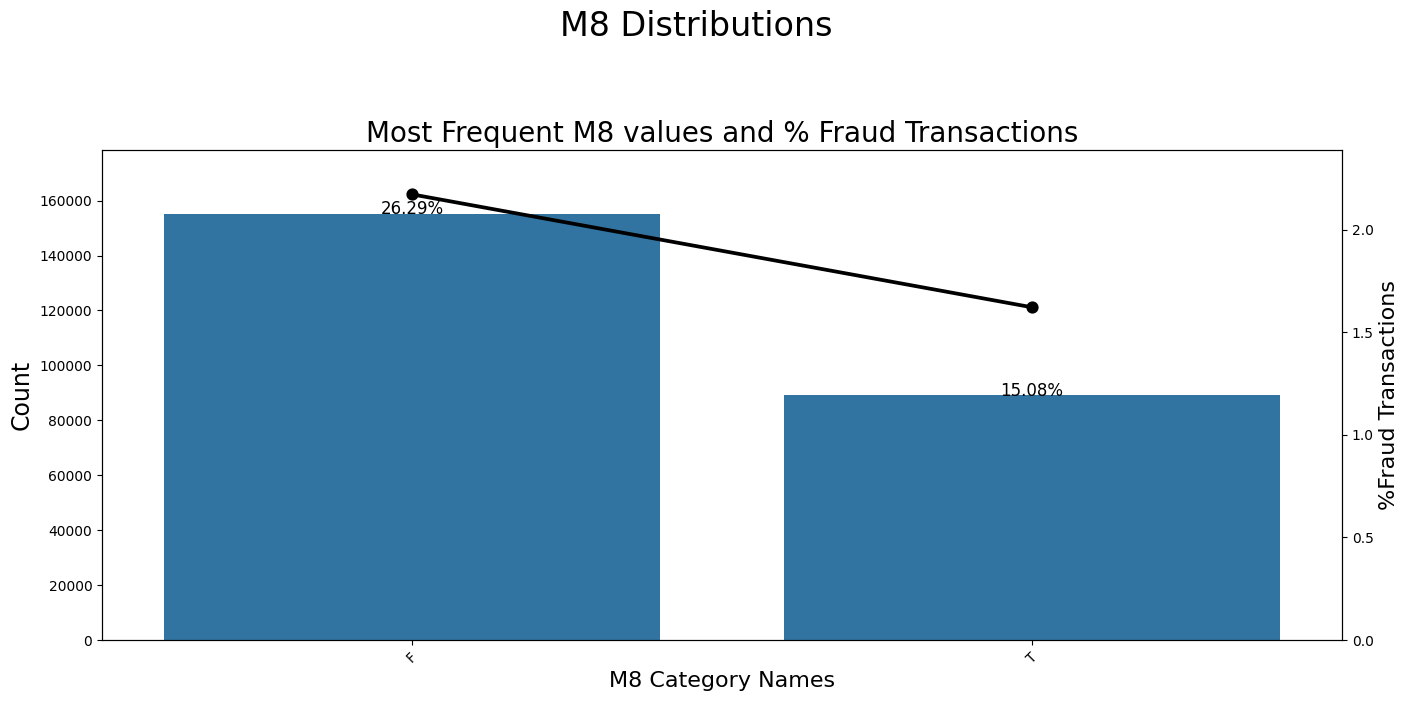

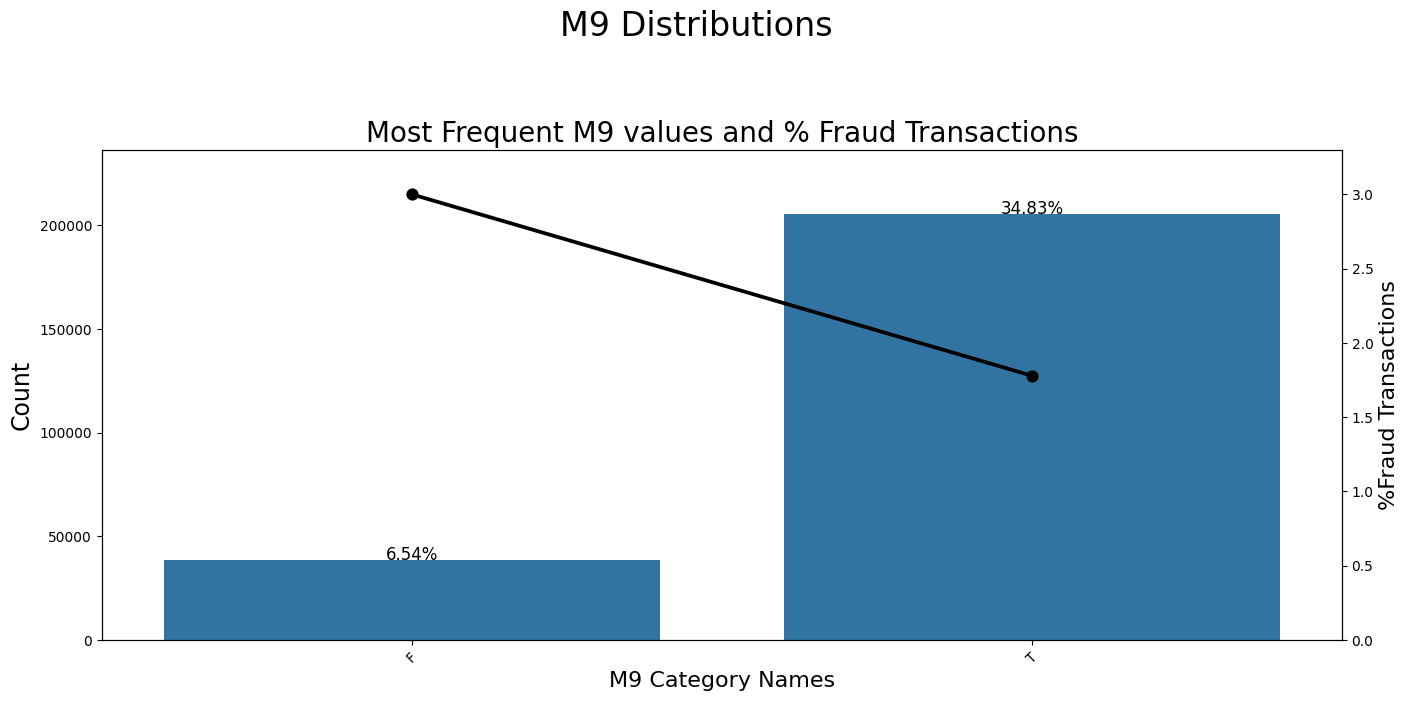

In [53]:
m_cols = [c for c in train if c[0] == 'M']
for col in m_cols:
    ploting_cnt_amt(train, col, lim=2500)

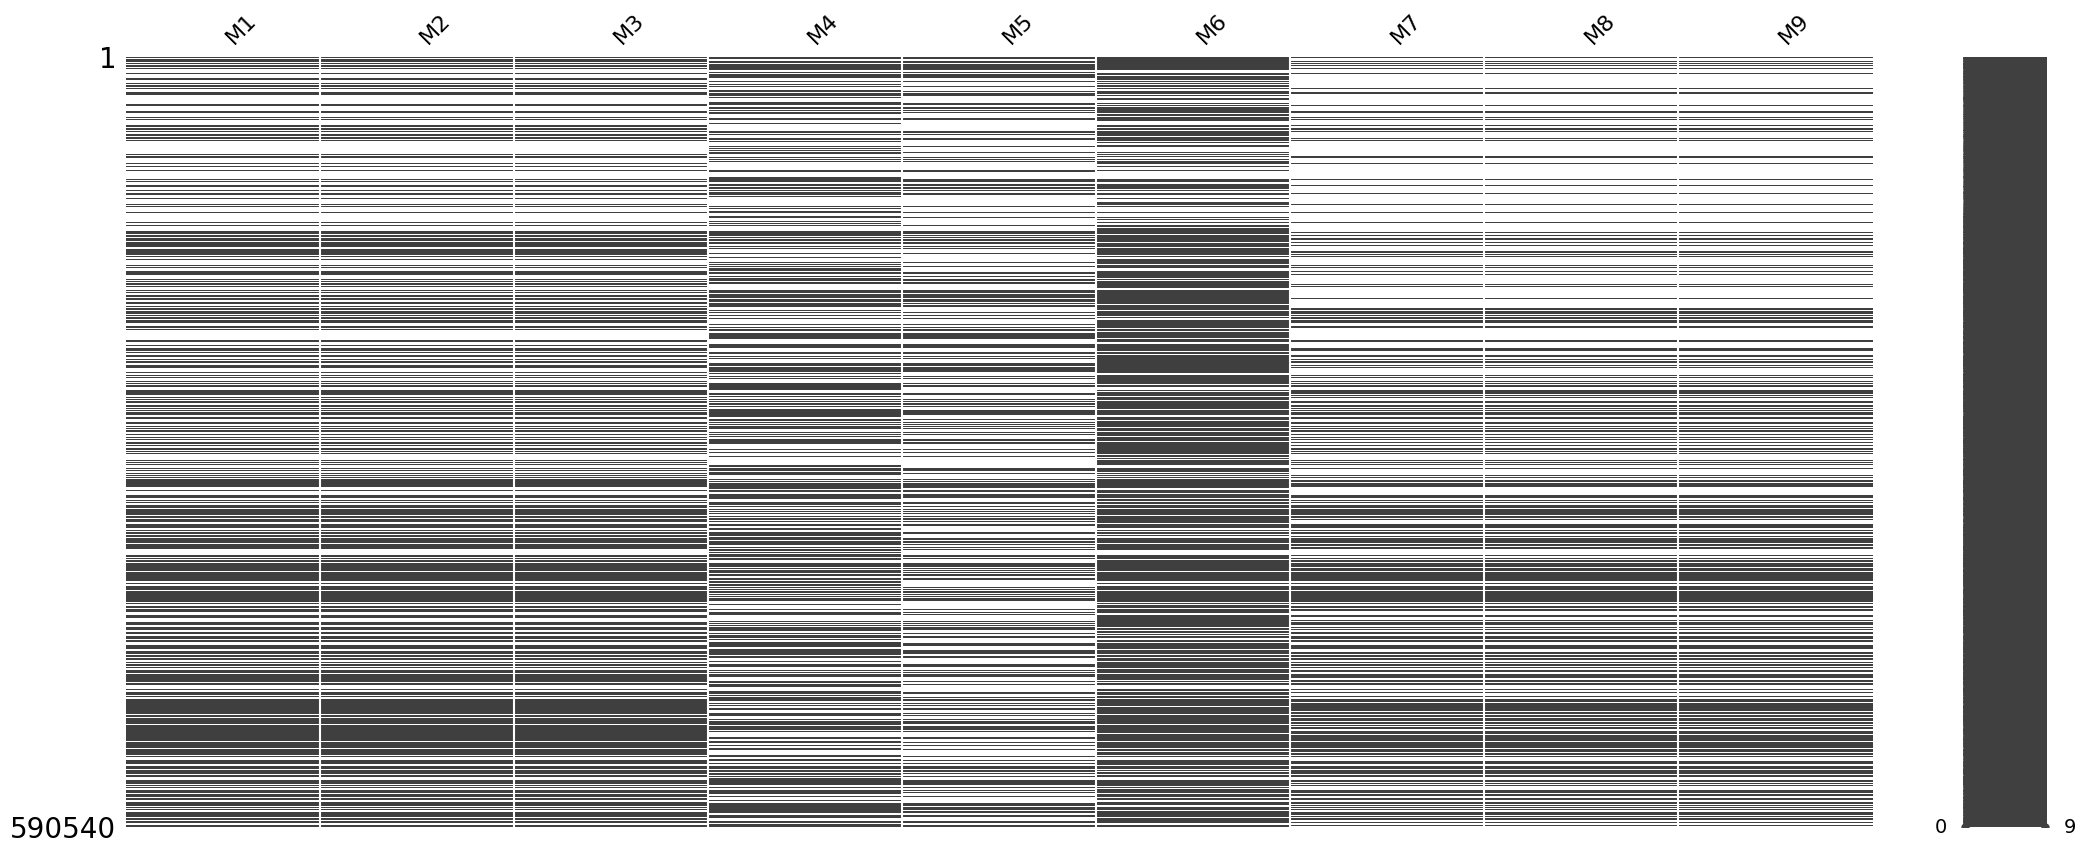

In [54]:
msno.matrix(train[m_cols]);

### V1-V339

* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
* I will group the v features that have a similar number of nan observations.

In [55]:
v_cols = [c for c in train if c[0] == 'V']
train[v_cols].head()

V1    V2    V3    V4    V5    V6    V7    V8    V9   V10   V11   V12  \
0 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 0.000 0.000 1.000   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN 0.000   
2 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 0.000 0.000 1.000   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V13   V14   V15   V16   V17   V18   V19   V20   V21   V22   V23   V24  \
0 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
1 0.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
2 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
3 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V25   V26   V27   V28   V29   V30   V31   V32   V33   V34   V35   V36  \
0 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   NaN   NaN   
1 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
2 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000   
3 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V37   V38   V39   V40   V41   V42   V43   V44   V45   V46   V47   V48  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000   
2 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000   
3 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V49   V50   V51   V52   V53   V54   V55   V56   V57   V58   V59   V60  \
0   NaN   NaN   NaN   NaN 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000   
1 0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 0.000 0.000   
2 0.000 0.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000   
3 0.000 0.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V61   V62   V63   V64   V65   V66   V67   V68   V69   V70   V71   V72  \
0 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
1 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
2 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
3 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V73   V74   V75   V76   V77   V78   V79   V80   V81   V82   V83   V84  \
0 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
1 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 0.000 1.000 1.000 0.000   
2 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 1.000 1.000 0.000   
3 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 1.000 1.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V85   V86   V87   V88   V89   V90   V91   V92   V93   V94   V95    V96  \
0 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000  1.000   
1 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000   
2 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000   
3 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 48.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN 0.000  0.000   

     V97   V98    V99  V100  V101   V102   V103  V104  V105  V106  V107  V108  \
0  0.000 0.000  0.000 0.000 0.000  1.000  0.000 0.000 0.000 0.000 1.000 1.000   
1  0.000 0.000  0.000 0.000 0.000  0.000  0.000 0.000 0.000 0.000 1.000 1.000   
2  0.000 0.000  0.000 0.000 0.000  0.000  0.000 0.00

In [56]:
train[v_cols].describe()

V1         V2         V3         V4         V5         V6  \
count 311253.000 311253.000 311253.000 311253.000 311253.000 311253.000   
mean       1.000      1.045      1.078      0.846      0.877      1.046   
std        0.007      0.240      0.321      0.440      0.476      0.239   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      1.000      1.000      1.000      1.000   
50%        1.000      1.000      1.000      1.000      1.000      1.000   
75%        1.000      1.000      1.000      1.000      1.000      1.000   
max        1.000      8.000      9.000      6.000      6.000      9.000   

              V7         V8         V9        V10        V11        V12  \
count 311253.000 311253.000 311253.000 311253.000 311253.000 514467.000   
mean       1.073      1.028      1.042      0.464      0.479      0.560   
std        0.305      0.186      0.226      0.522      0.552      0.511   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      1.000      0.000      0.000      0.000   
50%        1.000      1.000      1.000      0.000      0.000      1.000   
75%        1.000      1.000      1.000      1.000      1.000      1.000   
max        9.000      8.000      8.000      4.000      5.000      3.000   

             V13        V14        V15        V16        V17        V18  \
count 514467.000 514467.000 514467.000 514467.000 514467.000 514467.000   
mean       0.599      1.000      0.122      0.123      0.134      0.135   
std        0.532      0.022      0.332      0.343      0.364      0.372   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.000      1.000      0.000      0.000      0.000      0.000   
50%        1.000      1.000      0.000      0.000      0.000      0.000   
75%        1.000      1.000      0.000      0.000      0.000      0.000   
max        6.000      1.000      7.000     15.000     15.000     15.000   

             V19        V20        V21        V22        V23        V24  \
count 514467.000 514467.000 514467.000 514467.000 514467.000 514467.000   
mean       0.816      0.848      0.130      0.132      1.035      1.058   
std        0.426      0.459      0.339      0.359      0.248      0.305   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      0.000      0.000      1.000      1.000   
50%        1.000      1.000      0.000      0.000      1.000      1.000   
75%        1.000      1.000      0.000      0.000      1.000      1.000   
max        7.000     15.000      5.000      8.000     13.000     13.000   

             V25        V26        V27        V28        V29        V30  \
count 514467.000 514467.000 514467.000 514467.000 514467.000 514467.000   
mean       0.978      0.988      0.001      0.001      0.388      0.406   
std        0.185      0.209      0.029      0.031      0.511      0.554   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      0.000      0.000      0.000      0.000   
50%        1.000      1.000      0.000      0.000      0.000      0.000   
75%        1.000      1.000      0.000      0.000      1.000      1.000   
max        7.000     13.000      4.000      4.000      5.000      9.000   

             V31        V32        V33        V34        V35        V36  \
count 514467.000 514467.000 514467.000 514467.000 421571.000 421571.000   
mean       0.141      0.142      0.131      0.139      0.543      0.579   
std        0.356      0.368      0.341      0.358      0.516      0.539   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.000      0.000      0.000      0.000      0.000      0.000   
50%        0.000      0.000      0.000      0.000      1.000      1.000   
75%        0.000      0.000      0.000      0.000      1.000      1.000   
max        7.000     15.000      7

In [1]:
v_cols = [c for c in train_test if c[0] == 'V']
v_nan_df = train_test[v_cols].isna()
nan_groups={}

for col in v_cols:
    cur_group = v_nan_df[col].sum()
    try:
        nan_groups[cur_group].append(col)
    except:
        nan_groups[cur_group]=[col]
del v_nan_df; x=gc.collect()

NameError: name 'train_test' is not defined

In [ ]:
def plot_corr(v_cols):
    cols = v_cols + ['TransactionDT']
    plt.figure(figsize=(15,15))
    sns.heatmap(train[cols].corr(),cmap='RdBu_r', annot=True, center=0.0)
    plt.title(v_cols[0]+' - '+v_cols[-1],fontsize=14)
    plt.show()

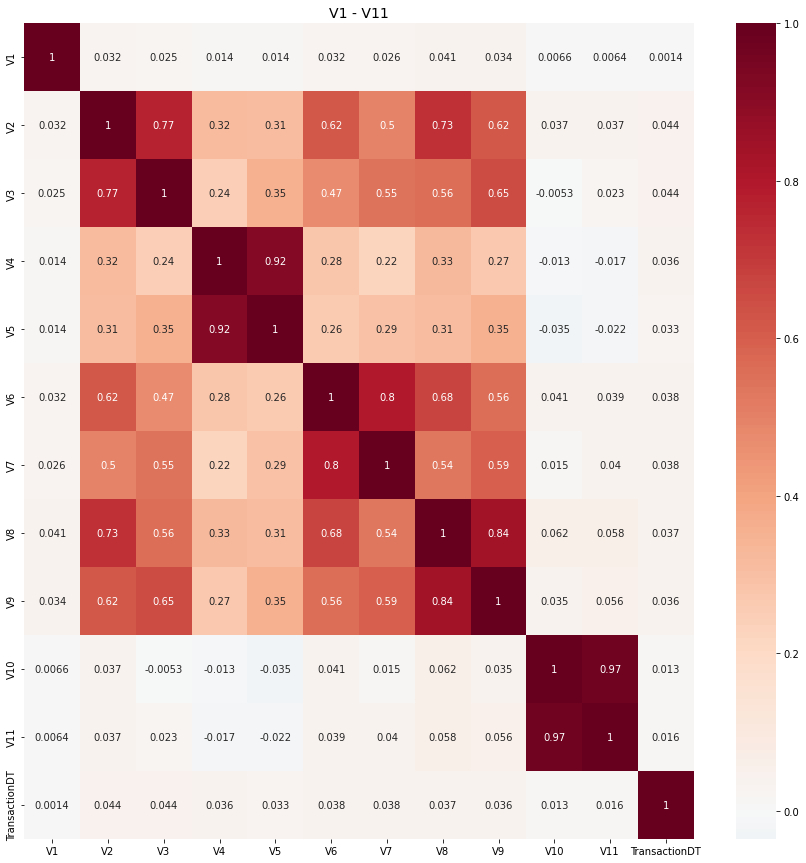

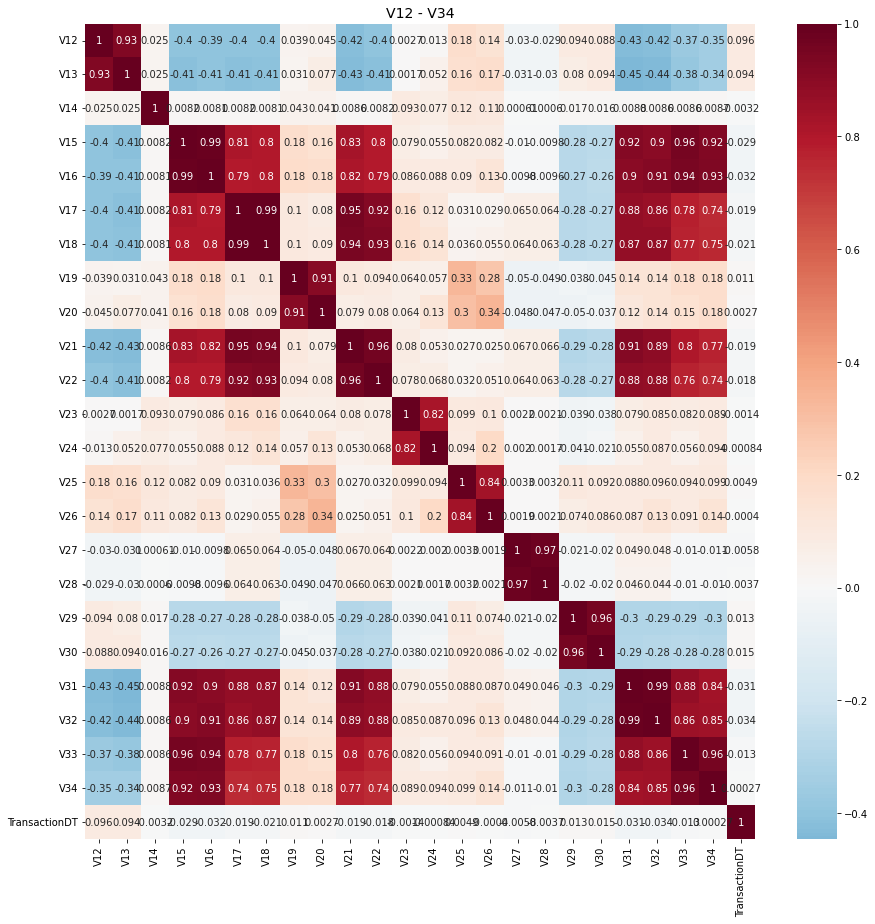

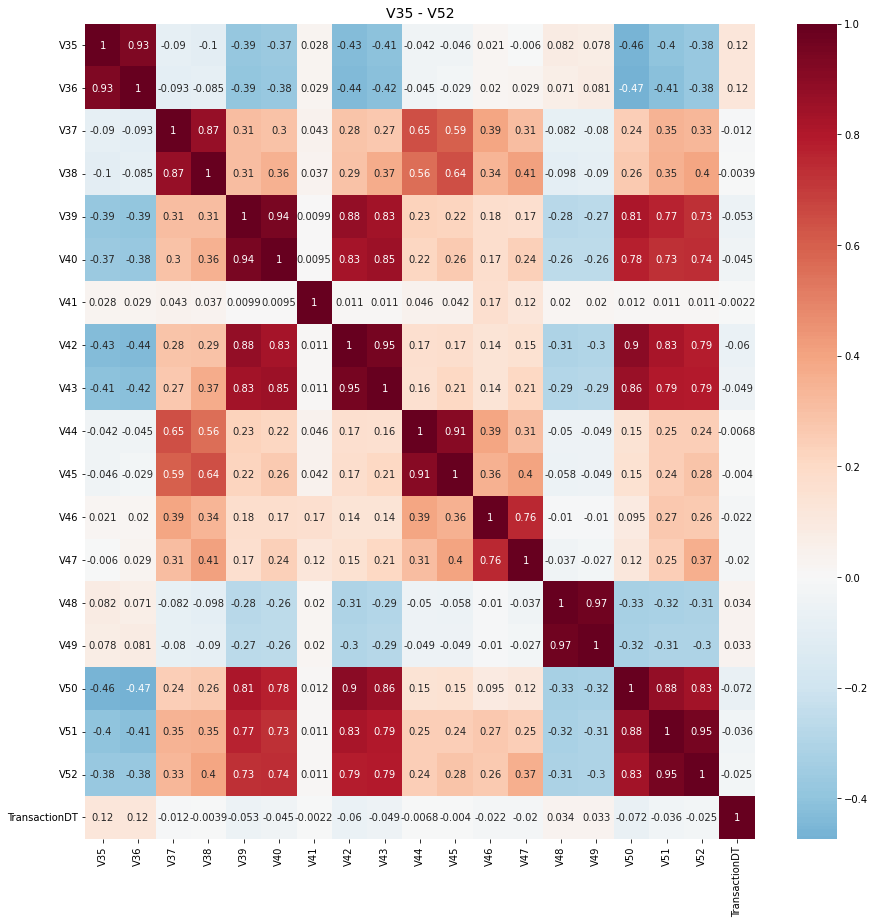

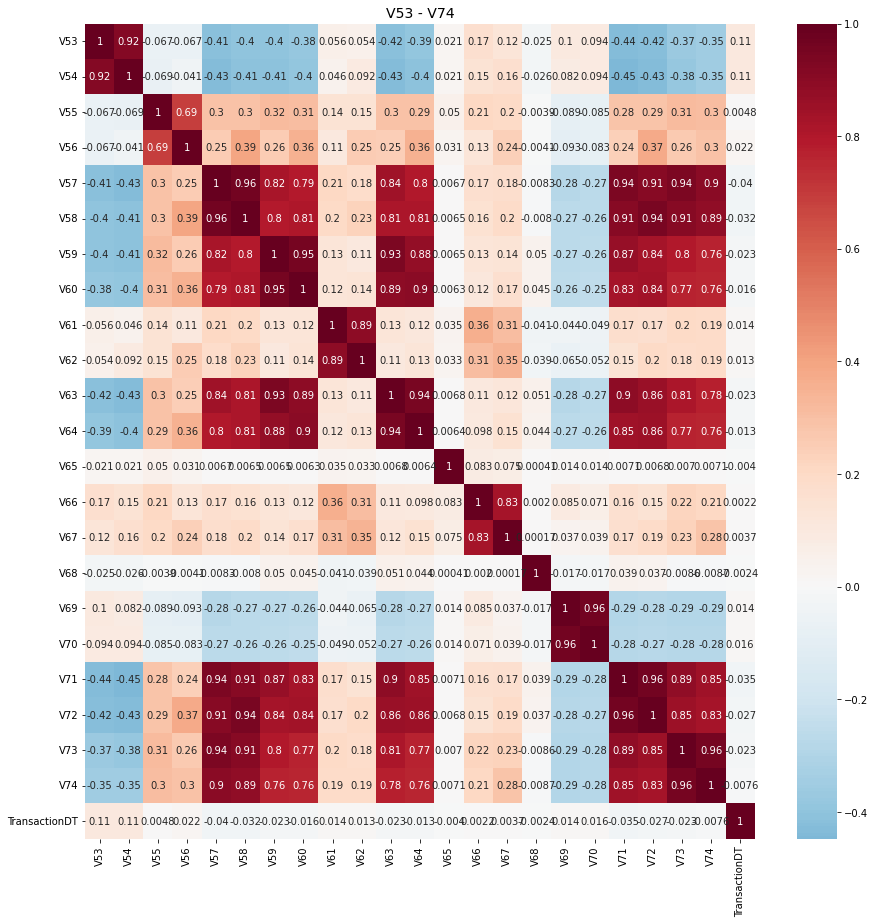

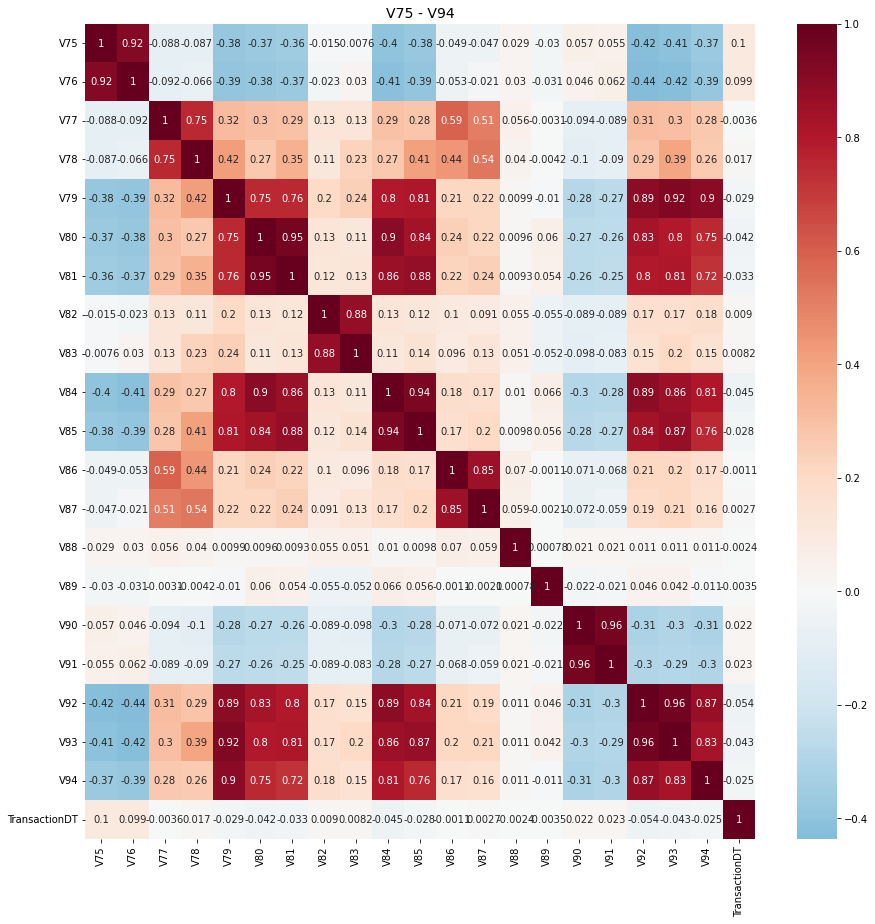

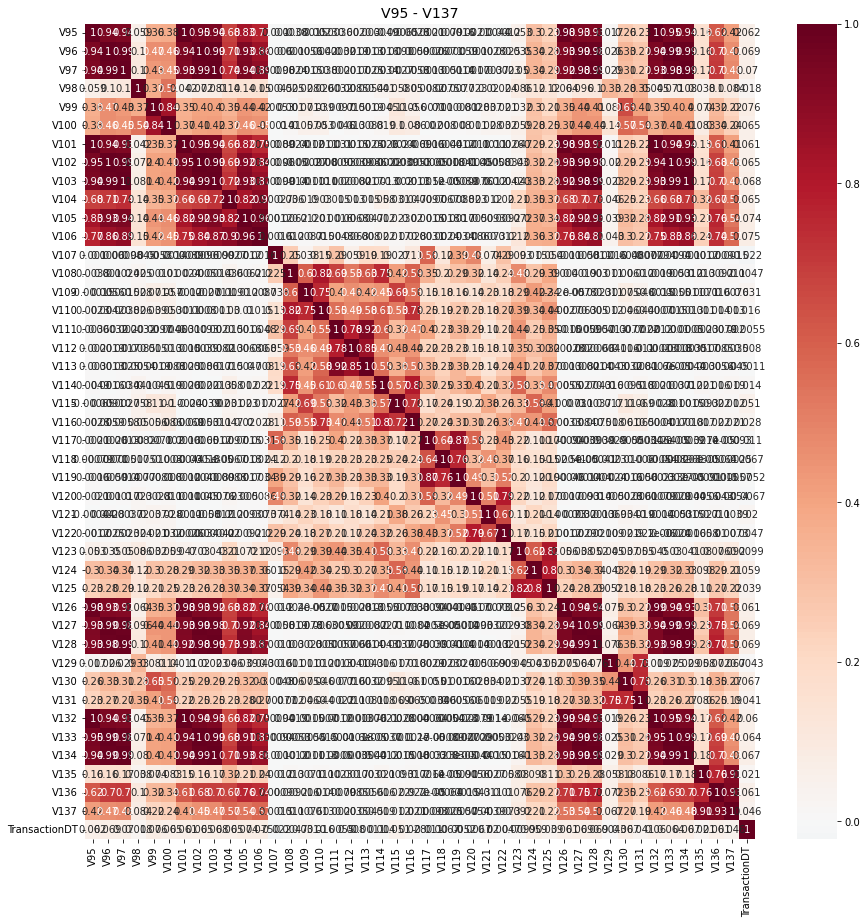

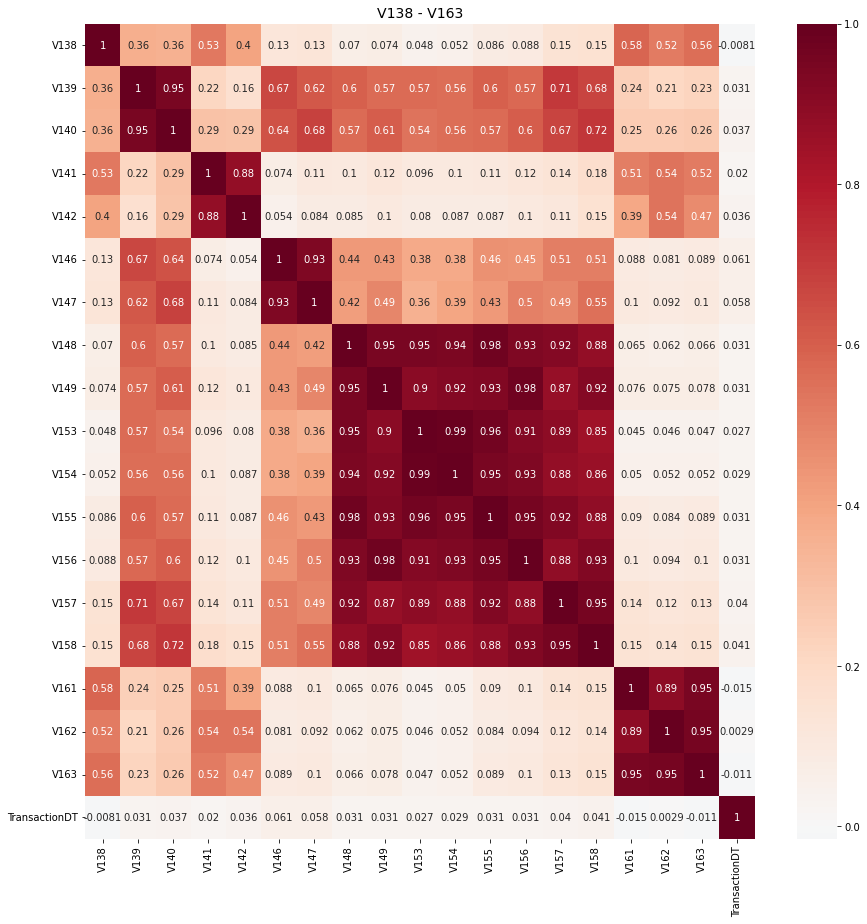

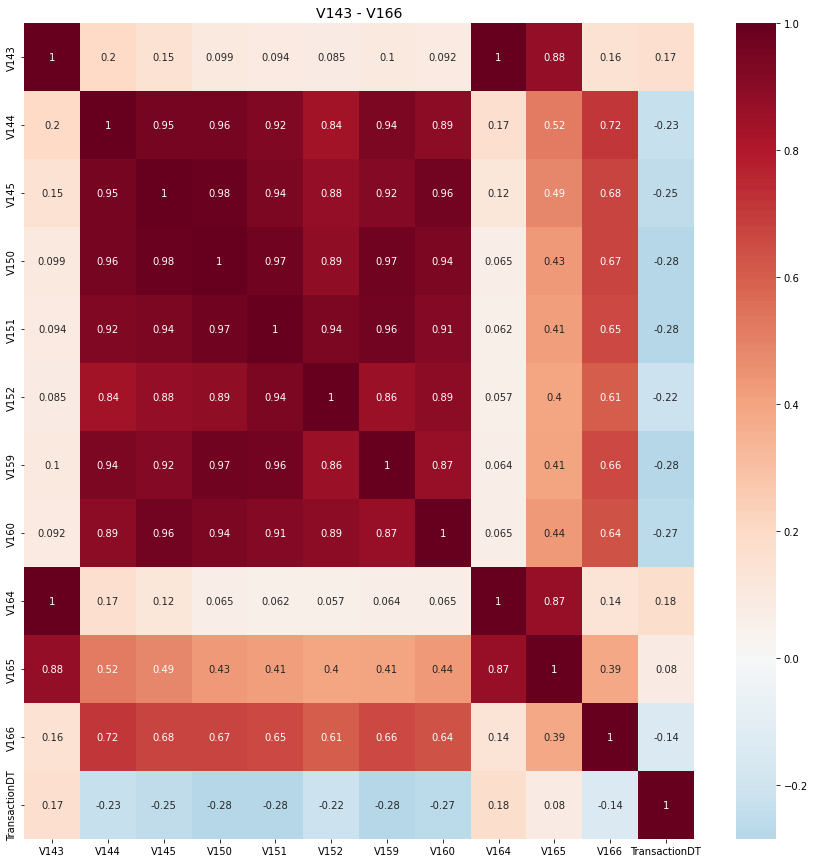

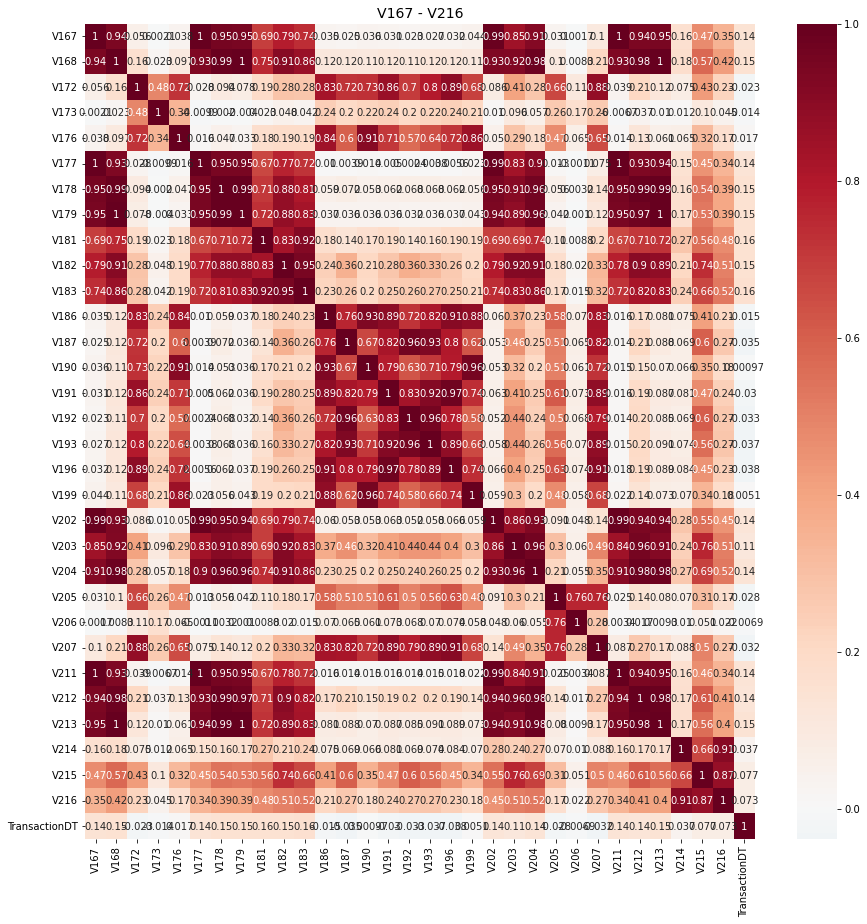

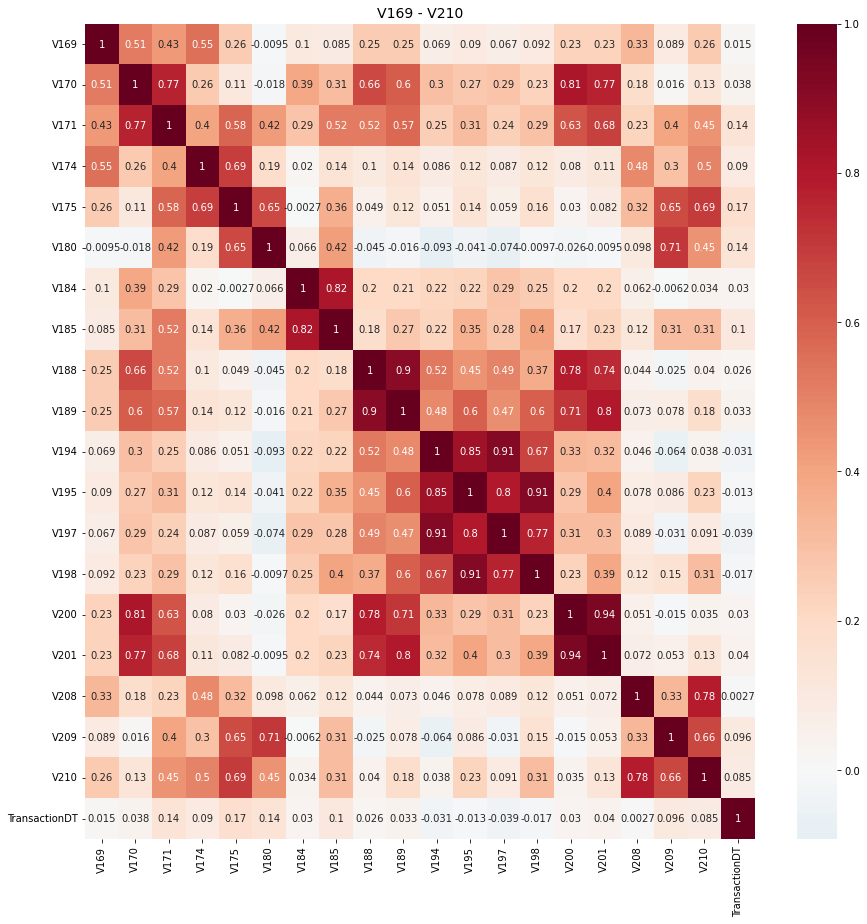

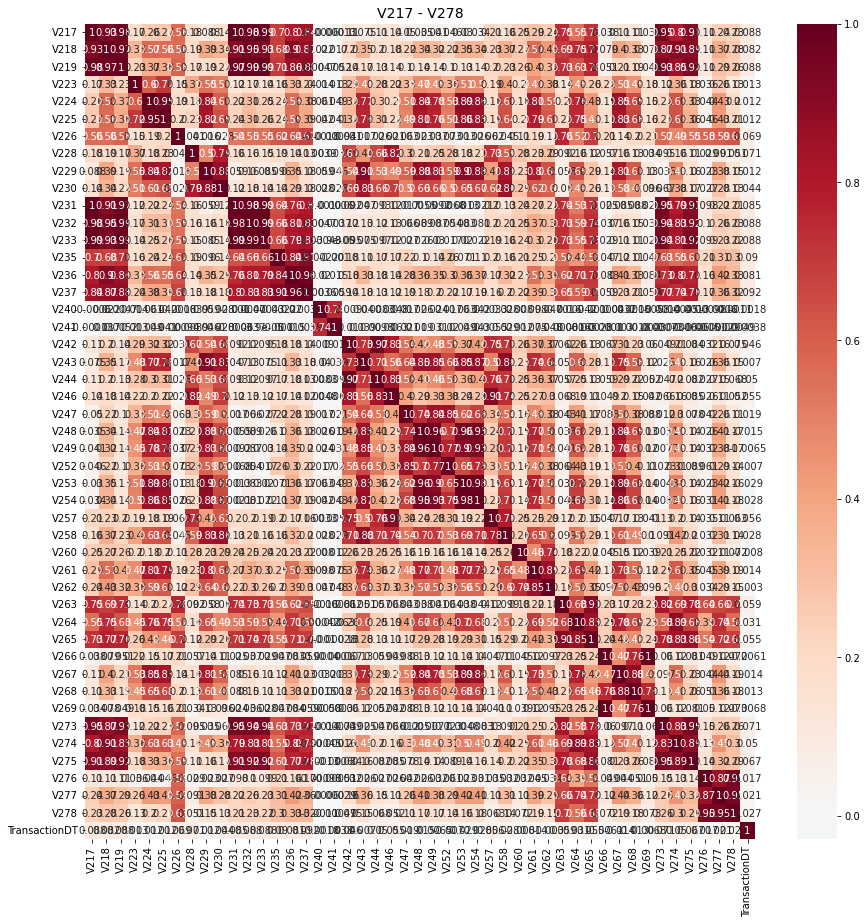

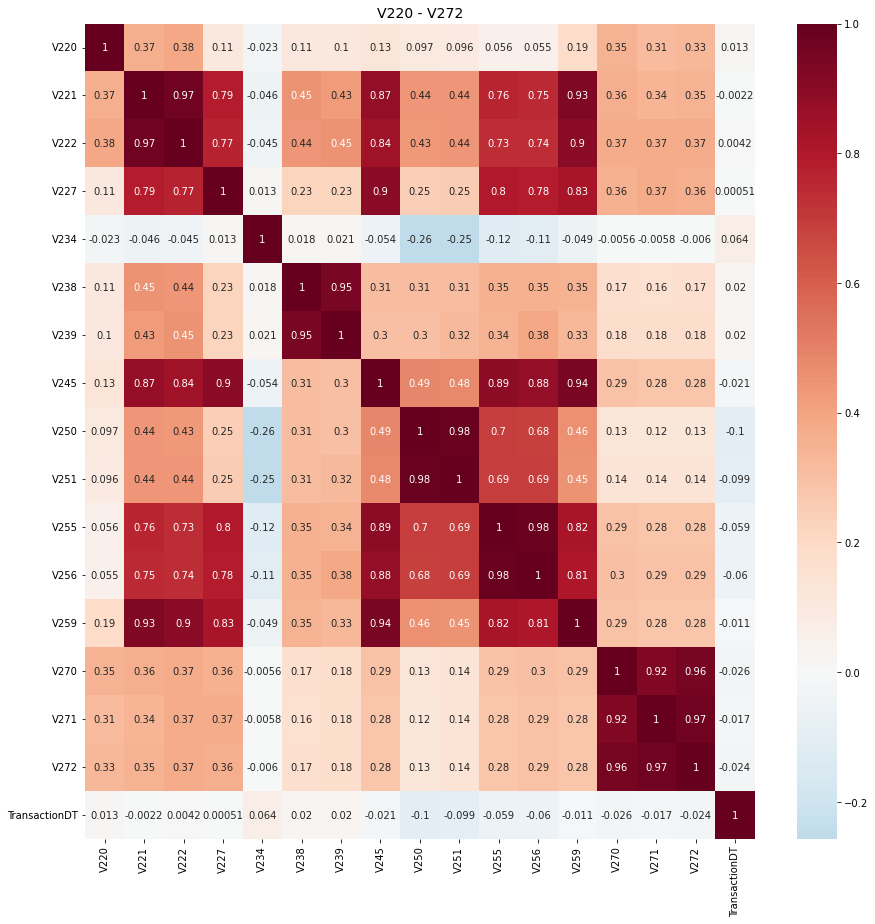

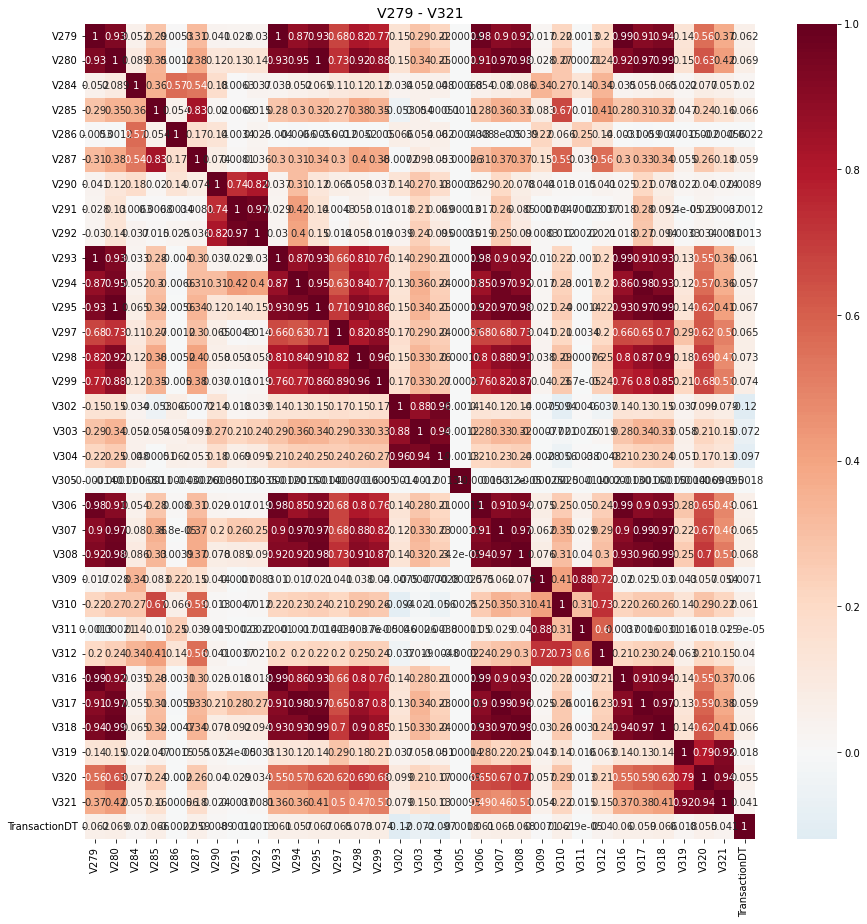

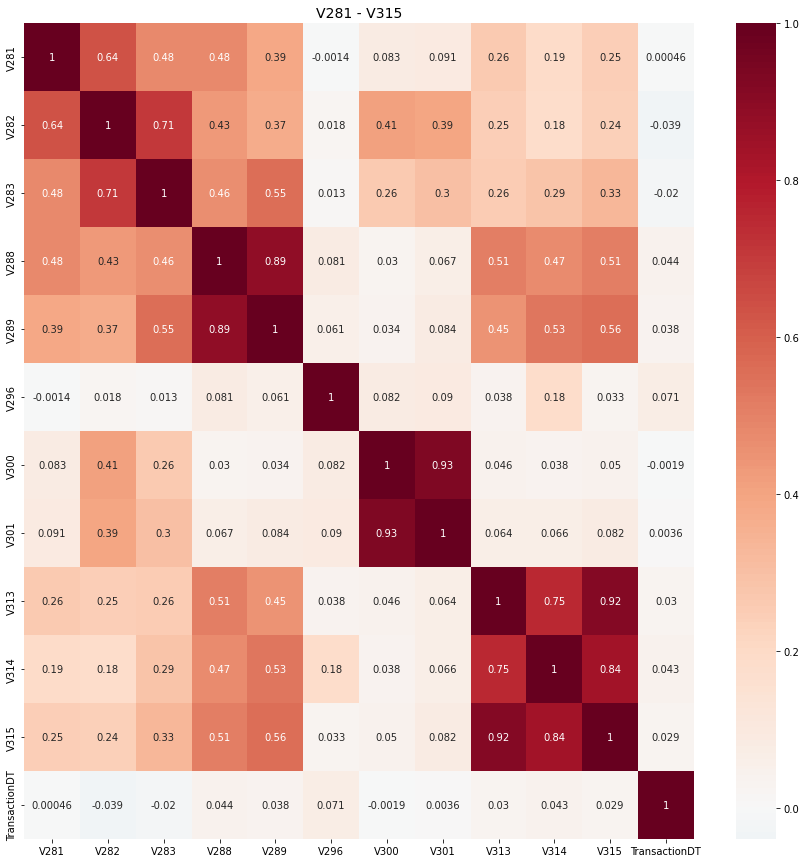

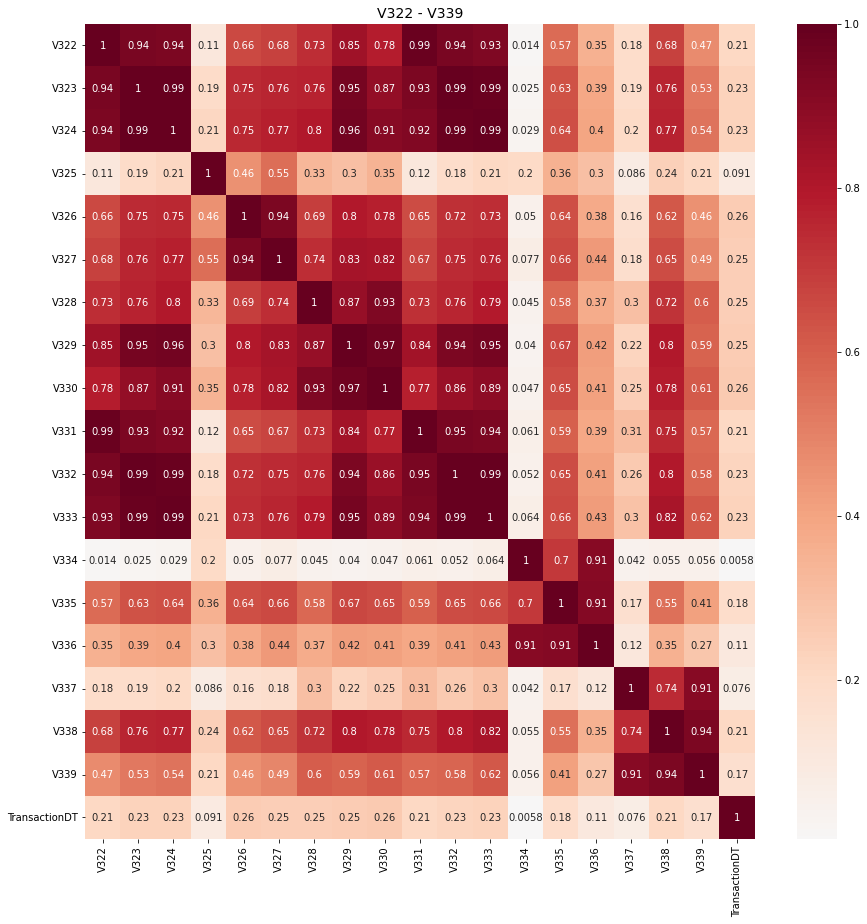

In [ ]:
for k,v in nan_groups.items():
    plot_corr(v)

### id1-id38

* id1-id11 are numeric features
* id12-id38 are categorical features.


In [ ]:
id_cols = [c for c in train_test if c[:2] == 'id']

id_num_cols=id_cols[:11]
id_cat_cols=id_cols[11:]

In [ ]:
train[id_num_cols].describe()

id_01      id_02     id_03     id_04      id_05      id_06  \
count 144233.000 140872.000 66324.000 66324.000 136865.000 136865.000   
mean     -10.171 174716.938     0.060    -0.059      1.616     -6.699   
std       14.343 159650.000     0.598     0.701      5.248     16.482   
min     -100.000      1.000   -13.000   -28.000    -72.000   -100.000   
25%      -10.000  67992.000     0.000     0.000      0.000     -6.000   
50%       -5.000 125800.500     0.000     0.000      0.000      0.000   
75%       -5.000 228749.000     0.000     0.000      1.000      0.000   
max        0.000 999595.000    10.000     0.000     52.000      0.000   

         id_07    id_08     id_09     id_10      id_11  
count 5155.000 5155.000 74926.000 74926.000 140978.000  
mean    13.285  -38.600     0.091    -0.301     99.744  
std     11.384   26.085     0.984     2.789      1.127  
min    -46.000 -100.000   -36.000  -100.000     90.000  
25%      5.000  -48.000     0.000     0.000    100.000  
50%     14.000  -34.000     0.000     0.000    100.000  
75%     22.000  -23.000     0.000     0.000    100.000  
max     61.000    0.000    25.000     0.000    100.000

In [ ]:
for col in id_num_cols:
    print('\n'+col)
    print(' Fraud mean    :  ' + str(train_fraud[col].mean()))
    print(' Non - Fraud mean:  ' + str(train_non_fraud[col].mean()))


id_01
 Fraud mean    :  -16.075632095336914
 Non - Fraud mean:  -9.667667388916016

id_02
 Fraud mean    :  201522.796875
 Non - Fraud mean:  172396.96875

id_03
 Fraud mean    :  0.13174915313720703
 Non - Fraud mean:  0.05159427225589752

id_04
 Fraud mean    :  -0.17969629168510437
 Non - Fraud mean:  -0.044433560222387314

id_05
 Fraud mean    :  1.4737752676010132
 Non - Fraud mean:  1.6279561519622803

id_06
 Fraud mean    :  -8.21398639678955
 Non - Fraud mean:  -6.566518306732178

id_07
 Fraud mean    :  10.070422172546387
 Non - Fraud mean:  13.574962615966797

id_08
 Fraud mean    :  -43.59624481201172
 Non - Fraud mean:  -38.15034866333008

id_09
 Fraud mean    :  0.17580170929431915
 Non - Fraud mean:  0.08113384991884232

id_10
 Fraud mean    :  -0.2109365016222
 Non - Fraud mean:  -0.3116439878940582

id_11
 Fraud mean    :  99.77584075927734
 Non - Fraud mean:  99.741455078125


In [ ]:
getCatFeatureDetail(train,id_cat_cols)

There are 27 categorical columns.
       nunique
id_12        2
id_13       54
id_14       25
id_15        3
id_16        2
id_17      104
id_18       18
id_19      522
id_20      394
id_21      490
id_22       25
id_23        3
id_24       12
id_25      341
id_26       95
id_27        2
id_28        2
id_29        2
id_30       75
id_31      130
id_32        4
id_33      260
id_34        4
id_35        2
id_36        2
id_37        2
id_38        2


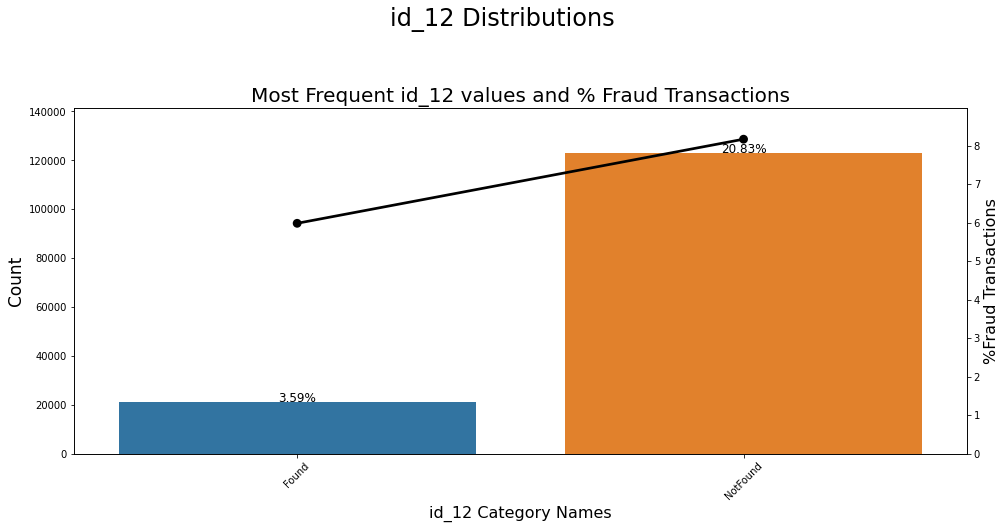

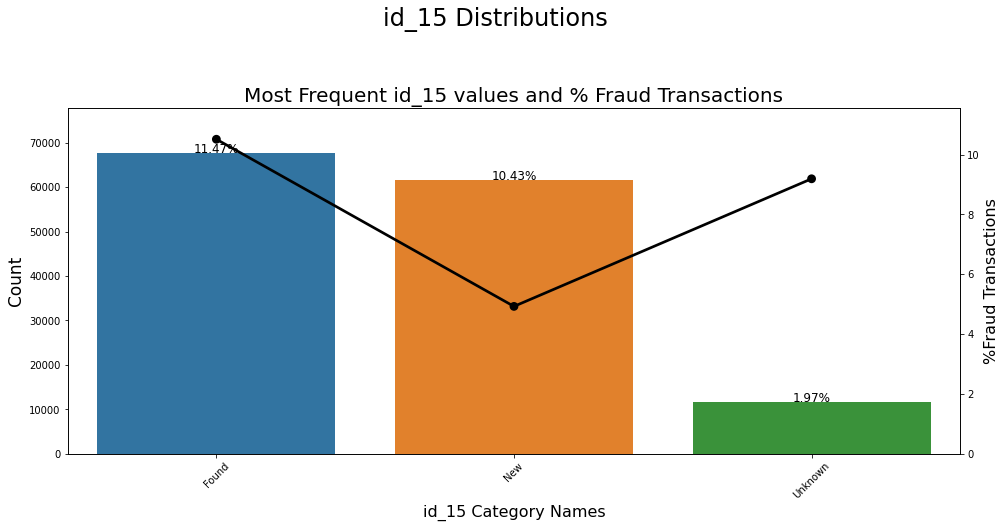

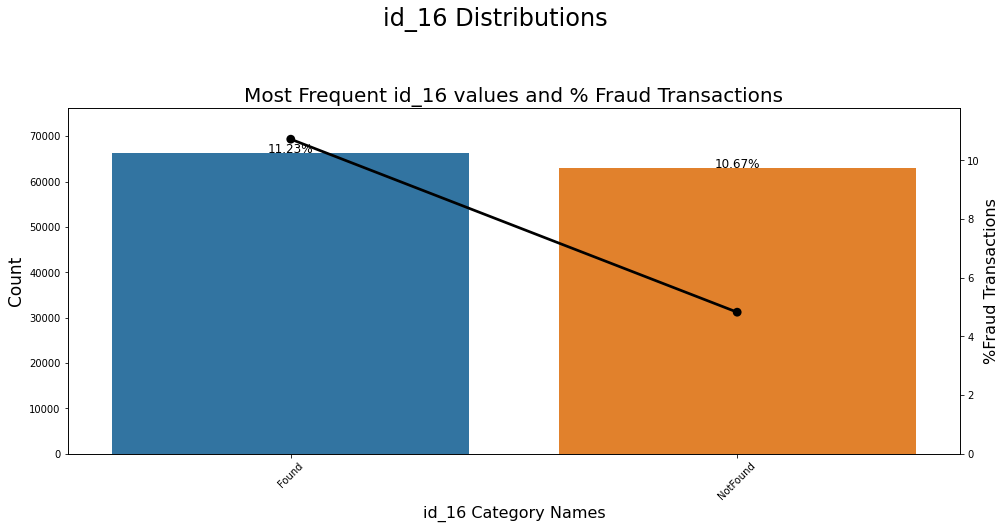

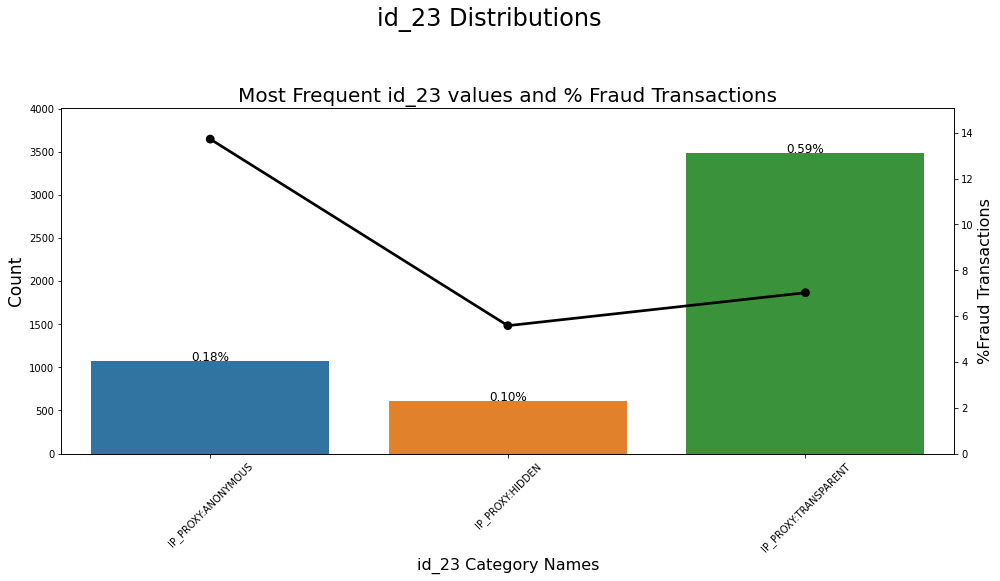

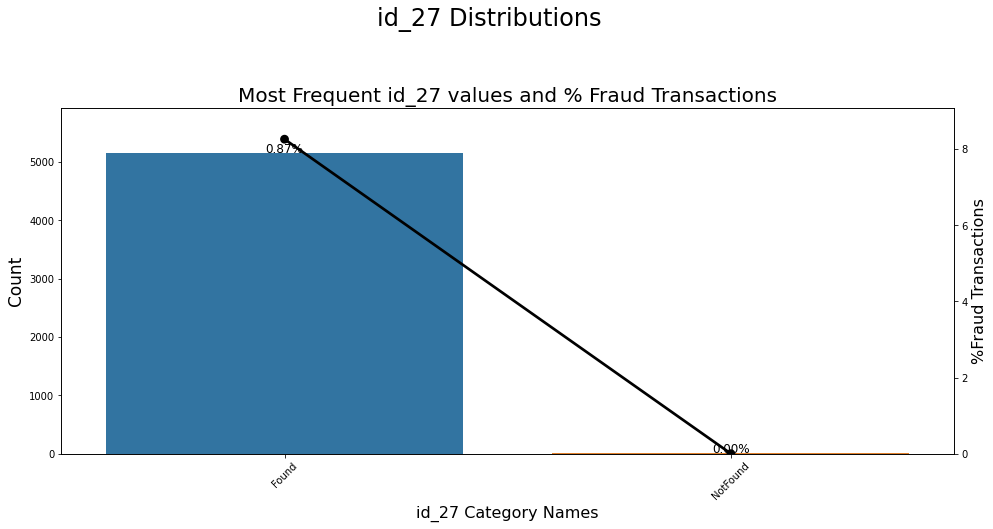

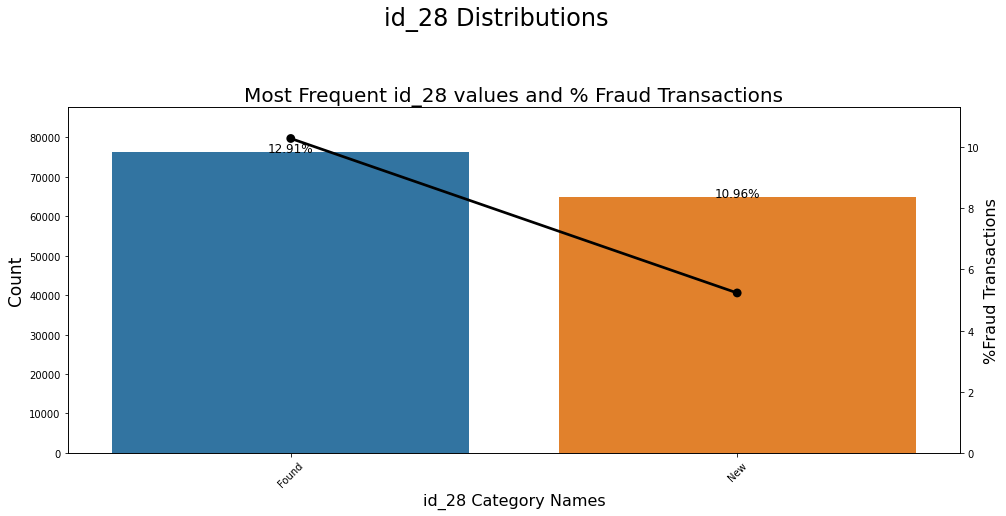

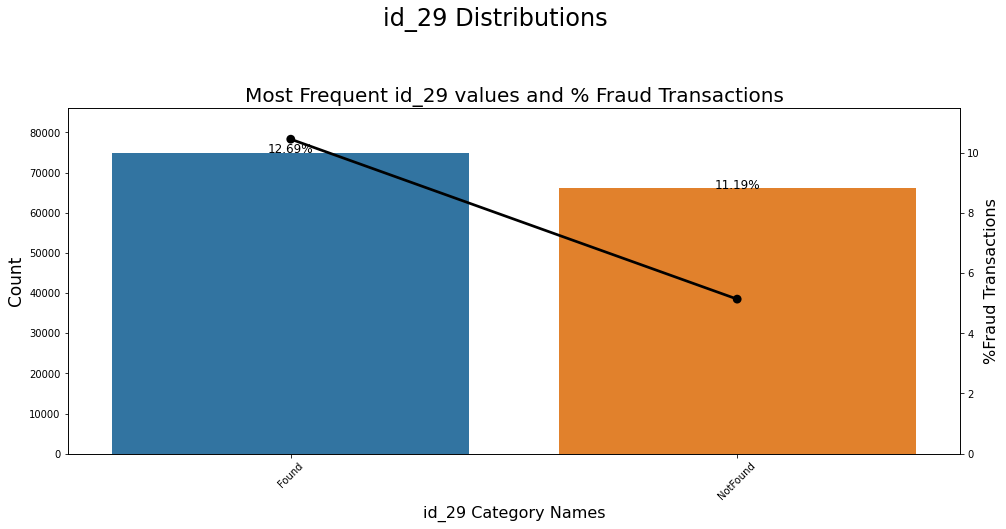

In [ ]:
for col in  ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29']:
    ploting_cnt_amt(train, col, lim=2500)

# MODEL TUNING

### Context Manager

In [ ]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 20))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def loading_data():
    print('LOADING DATA')
    train_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
    train_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

    test_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_transaction.csv")
    test_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_identity.csv")

    # Fix column name
    fix_col_name = {testIdCol:trainIdCol for testIdCol, trainIdCol in zip(test_identity.columns, train_identity.columns)}
    test_identity.rename(columns=fix_col_name, inplace=True)

    ## Reduce memory
    train_transaction = reduce_mem_usage(train_transaction)
    train_identity = reduce_mem_usage(train_identity)

    test_transaction = reduce_mem_usage(test_transaction)
    test_identity = reduce_mem_usage(test_identity)

    # Merge (transaction-identity)
    train = train_transaction.merge(train_identity, on='TransactionID', how='left')
    test = test_transaction.merge(test_identity, on='TransactionID', how='left')

    #MERGE (X_train - X_test)
    train_test = pd.concat([train, test], ignore_index=True)

    print(f'train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
    print(f'test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

    del train_transaction, train_identity, test_transaction, test_identity; x = gc.collect()
    return train_test

In [ ]:
def processing_data(train_test):
    print('PROCESSING DATA')
    drop_col_list = []

    # TransactionDT
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
    train_test['NewDate'] = train_test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
    train_test['NewDate_YMD'] = train_test['NewDate'].dt.year.astype(str) + '-' + train_test['NewDate'].dt.month.astype(str) + '-' + train_test['NewDate'].dt.day.astype(str)
    train_test['NewDate_YearMonth'] = train_test['NewDate'].dt.year.astype(str) + '-' + train_test['NewDate'].dt.month.astype(str)
    train_test['NewDate_Weekday'] = train_test['NewDate'].dt.dayofweek
    train_test['NewDate_Hour'] = train_test['NewDate'].dt.hour
    train_test['NewDate_Day'] = train_test['NewDate'].dt.day
    drop_col_list.extend(["TransactionDT","NewDate"])  ## !!!

    # TransactionAMT
    train_test['New_Cents'] = (train_test['TransactionAmt'] - np.floor(train_test['TransactionAmt'])).astype('float32')
    train_test['New_TransactionAmt_Bin'] = pd.qcut(train_test['TransactionAmt'],15)

    #cardX
    card_cols = [c for c in train_test if c[0:2] == 'ca']
    for col in ['card2','card3','card4','card5','card6']:
        train_test[col] = train_test.groupby(['card1'])[col].transform(lambda x: x.mode(dropna=False).iat[0])
        train_test[col].fillna(train_test[col].mode()[0], inplace=True)


    # P_email_domain & R_email_domain
    train_test.loc[train_test['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'
    train_test.loc[train_test['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk','yahoo.co.jp', 'yahoo.de', 'yahoo.fr','yahoo.es']), 'P_emaildomain'] = 'Yahoo'
    train_test.loc[train_test['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 'hotmail.es','hotmail.co.uk', 'hotmail.de','outlook.es', 'live.com', 'live.fr','hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
    train_test.loc[train_test['P_emaildomain'].isin(train_test['P_emaildomain'].value_counts()[train_test['P_emaildomain'].value_counts() <= 500 ].index), 'P_emaildomain'] = "Others"
    train_test['P_emaildomain'].fillna("Unknown", inplace=True)

    train_test.loc[train_test['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'
    train_test.loc[train_test['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk','yahoo.co.jp', 'yahoo.de', 'yahoo.fr','yahoo.es']), 'R_emaildomain'] = 'Yahoo'
    train_test.loc[train_test['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 'hotmail.es','hotmail.co.uk', 'hotmail.de','outlook.es', 'live.com', 'live.fr','hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
    train_test.loc[train_test['R_emaildomain'].isin(train_test['R_emaildomain'].value_counts()[train_test['R_emaildomain'].value_counts() <= 300 ].index), 'R_emaildomain'] = "Others"
    train_test['R_emaildomain'].fillna("Unknown", inplace=True)

    # DeviceInfo
    train_test['DeviceInfo'] = train_test['DeviceInfo'].fillna('unknown_device').str.lower()
    train_test['DeviceInfo'] = train_test['DeviceInfo'].str.split('/', expand=True)[0]

    train_test.loc[train_test['DeviceInfo'].str.contains('SM', na=False), 'DeviceInfo'] = 'Samsung'
    train_test.loc[train_test['DeviceInfo'].str.contains('SAMSUNG', na=False), 'DeviceInfo'] = 'Samsung'
    train_test.loc[train_test['DeviceInfo'].str.contains('GT-', na=False), 'DeviceInfo'] = 'Samsung'
    train_test.loc[train_test['DeviceInfo'].str.contains('Moto G', na=False), 'DeviceInfo'] = 'Motorola'
    train_test.loc[train_test['DeviceInfo'].str.contains('Moto', na=False), 'DeviceInfo'] = 'Motorola'
    train_test.loc[train_test['DeviceInfo'].str.contains('moto', na=False), 'DeviceInfo'] = 'Motorola'
    train_test.loc[train_test['DeviceInfo'].str.contains('LG-', na=False), 'DeviceInfo'] = 'LG'
    train_test.loc[train_test['DeviceInfo'].str.contains('rv:', na=False), 'DeviceInfo'] = 'RV'
    train_test.loc[train_test['DeviceInfo'].str.contains('HUAWEI', na=False), 'DeviceInfo'] = 'Huawei'
    train_test.loc[train_test['DeviceInfo'].str.contains('ALE-', na=False), 'DeviceInfo'] = 'Huawei'
    train_test.loc[train_test['DeviceInfo'].str.contains('-L', na=False), 'DeviceInfo'] = 'Huawei'
    train_test.loc[train_test['DeviceInfo'].str.contains('Blade', na=False), 'DeviceInfo'] = 'ZTE'
    train_test.loc[train_test['DeviceInfo'].str.contains('BLADE', na=False), 'DeviceInfo'] = 'ZTE'
    train_test.loc[train_test['DeviceInfo'].str.contains('Linux', na=False), 'DeviceInfo'] = 'Linux'
    train_test.loc[train_test['DeviceInfo'].str.contains('XT', na=False), 'DeviceInfo'] = 'Sony'
    train_test.loc[train_test['DeviceInfo'].str.contains('HTC', na=False), 'DeviceInfo'] = 'HTC'
    train_test.loc[train_test['DeviceInfo'].str.contains('ASUS', na=False), 'DeviceInfo'] = 'Asus'

    train_test.loc[train_test['DeviceInfo'].isin(train_test['DeviceInfo'].value_counts()[train_test['DeviceInfo'].value_counts() < 1000].index), 'DeviceInfo'] = "Others"

    # V1 - V339
    v_cols = [c for c in train_test if c[0] == 'V']
    v_nan_df = train_test[v_cols].isna()
    nan_groups={}

    for col in v_cols:
        cur_group = v_nan_df[col].sum()
        try:
            nan_groups[cur_group].append(col)
        except:
            nan_groups[cur_group]=[col]
    del v_nan_df; x=gc.collect()

    for nan_cnt, v_group in nan_groups.items():
        train_test['New_v_group_'+str(nan_cnt)+'_nulls'] = nan_cnt
        sc = preprocessing.MinMaxScaler()
        pca = PCA(n_components=2)
        v_group_pca = pca.fit_transform(sc.fit_transform(train_test[v_group].fillna(-1)))
        train_test['New_v_group_'+str(nan_cnt)+'_pca0'] = v_group_pca[:,0]
        train_test['New_v_group_'+str(nan_cnt)+'_pca1'] = v_group_pca[:,1]

    drop_col_list.extend(v_cols)

    print('CREATING NEW FEATURES')

    train_test['New_card1_card2']=train_test['card1'].astype(str)+'_'+train_test['card2'].astype(str)
    train_test['New_addr1_addr2']=train_test['addr1'].astype(str)+'_'+train_test['addr2'].astype(str)
    train_test['New_card1_card2_addr1_addr2']=train_test['card1'].astype(str)+'_'+train_test['card2'].astype(str)+'_'+train_test['addr1'].astype(str)+'_'+train_test['addr2'].astype(str)

    train_test['New_P_emaildomain_addr1'] = train_test['P_emaildomain'] + '_' + train_test['addr1'].astype(str)
    train_test['New_R_emaildomain_addr2'] = train_test['R_emaildomain'] + '_' + train_test['addr2'].astype(str)

    #Aggregation features
    train_test['New_TransactionAmt_to_mean_card1'] = train_test['TransactionAmt'] / train_test.groupby(['card1'])['TransactionAmt'].transform('mean')
    train_test['New_TransactionAmt_to_mean_card4'] = train_test['TransactionAmt'] / train_test.groupby(['card4'])['TransactionAmt'].transform('mean')
    train_test['New_TransactionAmt_to_std_card1'] = train_test['TransactionAmt'] / train_test.groupby(['card1'])['TransactionAmt'].transform('std')
    train_test['TransactionAmt_to_std_card4'] = train_test['TransactionAmt'] / train_test.groupby(['card4'])['TransactionAmt'].transform('std')

    train_test['New_id_02_to_mean_card1'] = train_test['id_02'] / train_test.groupby(['card1'])['id_02'].transform('mean')
    train_test['New_id_02_to_mean_card4'] = train_test['id_02'] / train_test.groupby(['card4'])['id_02'].transform('mean')
    train_test['New_id_02_to_std_card1'] = train_test['id_02'] / train_test.groupby(['card1'])['id_02'].transform('std')
    train_test['New_id_02_to_std_card4'] = train_test['id_02'] / train_test.groupby(['card4'])['id_02'].transform('std')

    train_test['New_D15_to_mean_card1'] = train_test['D15'] / train_test.groupby(['card1'])['D15'].transform('mean')
    train_test['New_D15_to_mean_card4'] = train_test['D15'] / train_test.groupby(['card4'])['D15'].transform('mean')
    train_test['New_D15_to_std_card1'] = train_test['D15'] / train_test.groupby(['card1'])['D15'].transform('std')
    train_test['New_D15_to_std_card4'] = train_test['D15'] / train_test.groupby(['card4'])['D15'].transform('std')

    train_test['New_D15_to_mean_addr1'] = train_test['D15'] / train_test.groupby(['addr1'])['D15'].transform('mean')
    train_test['New_D15_to_mean_card4'] = train_test['D15'] / train_test.groupby(['card4'])['D15'].transform('mean')
    train_test['New_D15_to_std_addr1'] = train_test['D15'] / train_test.groupby(['addr1'])['D15'].transform('std')
    train_test['New_D15_to_std_card4'] = train_test['D15'] / train_test.groupby(['card4'])['D15'].transform('std')

    drop_col_list.extend(card_cols)

    # Frequency Encoding
    fe_col_list=["New_TransactionAmt_Bin",'card4','card6','P_emaildomain','R_emaildomain','DeviceType','DeviceInfo']+[c for c in train_test if c[0] == 'M']
    for col in fe_col_list:
        vc = train_test[col].value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = 'New_'+col+'_FE'
        train_test[nm] = train_test[col].map(vc)
        train_test[nm] = train_test[nm].astype('float32')


    print('DROPING UNNECESSARY FEATURES')
    train_test=train_test.drop(drop_col_list, axis=1)

    print('APPLYING LABEL ENCODING TO CATEGORICAL FEATURES')
    for col in train_test.columns:
        if train_test[col].dtype == 'object':
            le = LabelEncoder()
            le.fit(list(train_test[col].astype(str).values))
            train_test[col] = le.transform(list(train_test[col].astype(str).values))

    print('REDUCING MEMORY USAGE')
    train_test = reduce_mem_usage(train_test)

    print('DATA IS READY TO MODELLING')

    return train_test

In [ ]:
def modeling(train_test,target):

    train = train_test[train_test[target].notnull()]
    test = train_test[train_test[target].isnull()]

    folds = KFold(n_splits = 10, shuffle = True, random_state = 1001)

    oof_preds = np.zeros(train.shape[0])
    sub_preds = np.zeros(test.shape[0])

    feature_importance_df = pd.DataFrame()

    features = [f for f in train.columns if f not in [target,'TransactionID','New_TransactionAmt_Bin','NewDate']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[features], train[target])):

        start_time = time.time()
        print('Training on fold {}'.format(n_fold + 1))

        X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]

        X_valid, y_valid = train[features].iloc[valid_idx], train[target].iloc[valid_idx]

        params={'learning_rate': 0.01,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 1,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85 }

        clf = LGBMClassifier(**params, n_estimators=1000) #categorical_feature = LGBM_cat_col_list

        clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                eval_metric = 'auc', verbose = 200, early_stopping_rounds = 200)

        #y_pred_valid
        oof_preds[valid_idx] = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(y_valid, oof_preds[valid_idx])))


    print('Full AUC score %.6f' % roc_auc_score(train[target], oof_preds)) #y_pred_valid

    test[target] = sub_preds
    test[['TransactionID', target]].to_csv("submission_lightgbm2.csv", index= False)

    display_importances(feature_importance_df)

    return feature_importance_df

In [ ]:
def main():
    with timer("Loading Data"):
        train_test = loading_data()

    with timer("Preprocessing Data"):
        train_test = processing_data(train_test)

    with timer("Modeling"):
        feat_importance = modeling(train_test ,'isFraud')

LOADING DATA
Mem. usage decreased to 916.30 Mb (48.4% reduction)
Mem. usage decreased to 31.91 Mb (29.3% reduction)
Mem. usage decreased to 785.71 Mb (48.3% reduction)
Mem. usage decreased to 31.40 Mb (29.3% reduction)
train dataset has 590540 rows and 434 columns.
test dataset has 506691 rows and 433 columns.
Loading Data - done in 257s
PROCESSING DATA


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  T

CREATING NEW FEATURES
DROPING UNNECESSARY FEATURES
APPLYING LABEL ENCODING TO CATEGORICAL FEATURES
REDUCING MEMORY USAGE
Mem. usage decreased to 626.80 Mb (36.6% reduction)
DATA IS READY TO MODELLING
Preprocessing Data - done in 208s
Training on fold 1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Info] Number of positive: 18615, number of negative: 51

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Modeling - done in 3381s
Full model run - done in 3845s


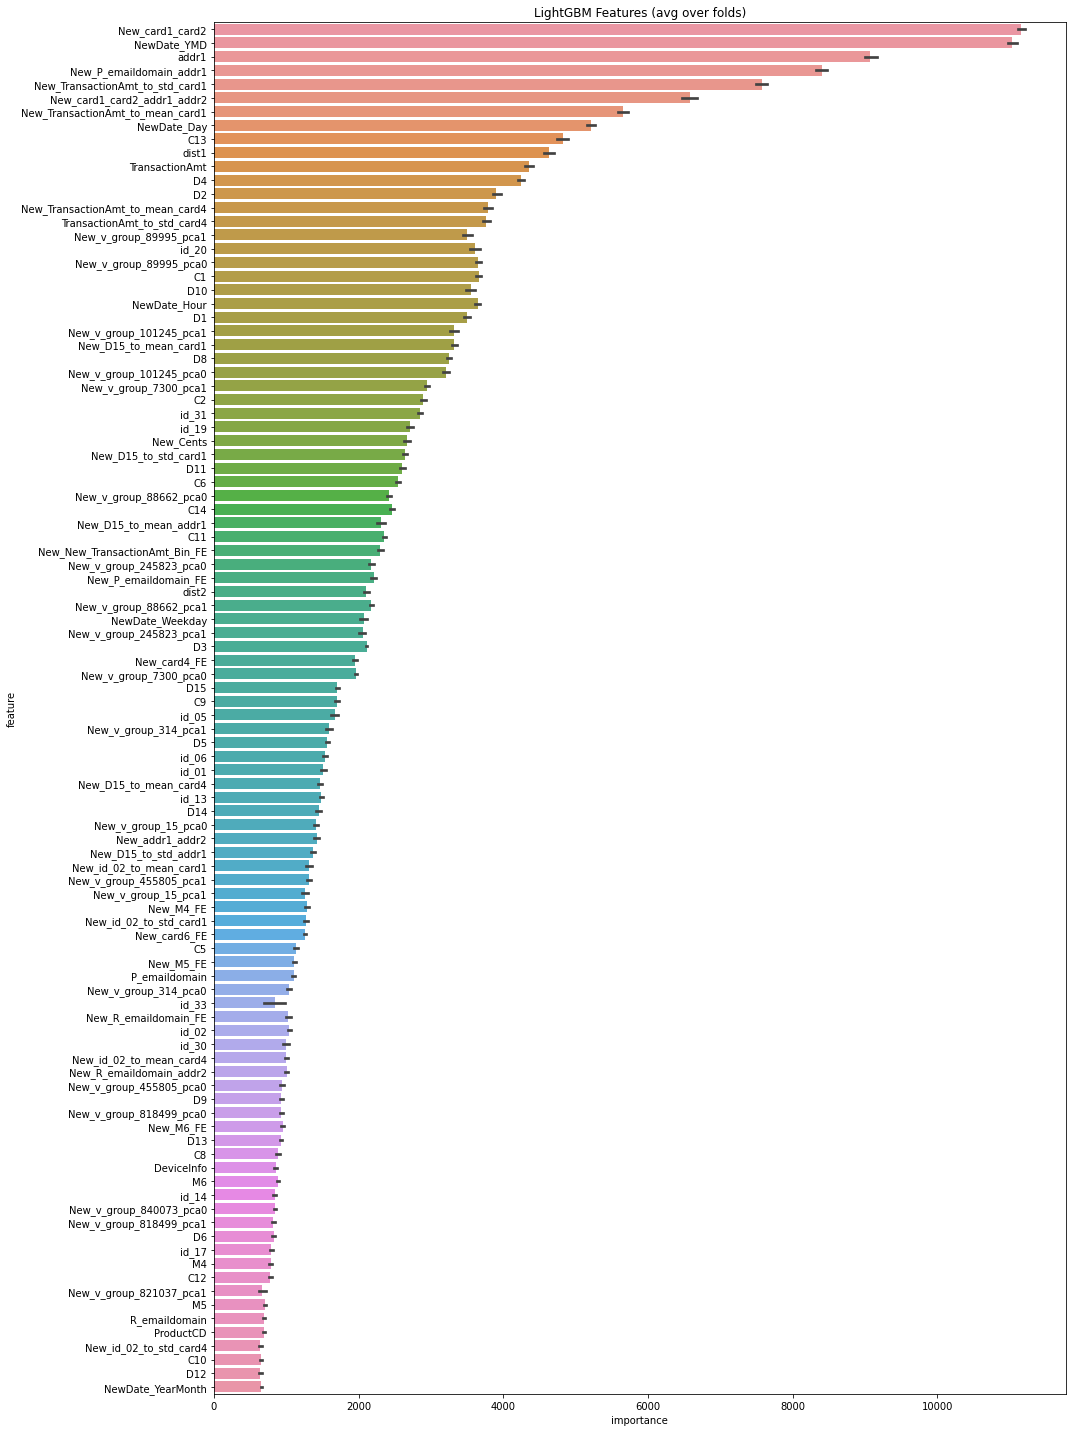

In [ ]:
if __name__ == "__main__":
    with timer("Full model run"):
        main()